In [175]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf

from tqdm import tqdm
from patsy import dmatrix
from scipy.spatial import distance
from statsmodels.stats.outliers_influence import summary_table
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score, train_test_split

## Question 6

In [176]:
wages = pd.read_csv('../../data/wage.csv')
wages.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


### 6.a

In [177]:
X_train, X_test, y_train, y_test = train_test_split(wages.age, wages.wage, test_size=0.4, random_state=1)

In [178]:
# Cross-validation method
MSEs = []

for i in np.arange(1, 8):
    poly = PolynomialFeatures(degree=i)
    lm = LinearRegression(fit_intercept=False)
    
    X_poly = poly.fit_transform(X_train.values.reshape(-1, 1))
    lm.fit(X_poly, y_train)
    
    pred = lm.predict(poly.transform(X_test.values.reshape(-1, 1)))
    MSEs.append(mean_squared_error(y_test, pred))

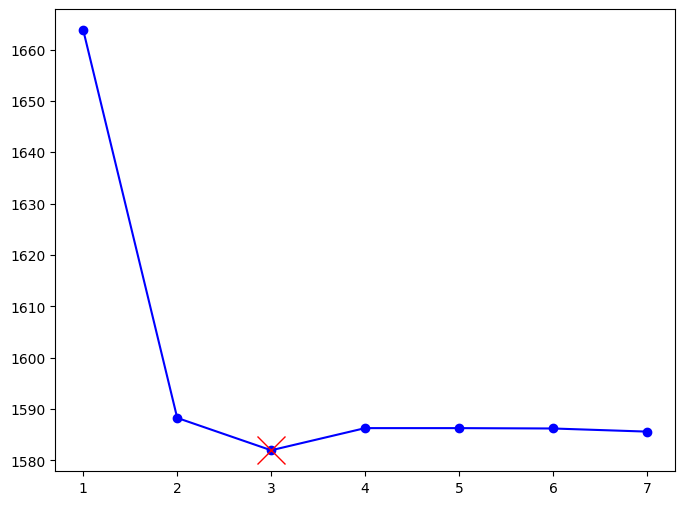

In [179]:
min_mse_idx, min_mse = np.argmin(MSEs), np.min(MSEs)

fig, axes = plt.subplots(1,1, figsize=(8,6))
axes.plot(np.arange(1,8), MSEs, color='b', marker='o')
axes.plot(min_mse_idx+1, min_mse, color='r', marker='x', markersize=20)

In [180]:
df = pd.concat([wages.wage, wages.age], axis=1)

for i in range(2, 8):
    df[f'age{i}'] = np.power(df.age, i)

df.head(2)

,wage,age,age2,age3,age4,age5,age6,age7
0,75.043154,18,324,5832,104976,1889568,34012224,612220032
1,70.476020,24,576,13824,331776,7962624,191102976,4586471424


In [181]:
# Hypothesis Testing using ANOVA

models = []

for i in range(1, 8):
    formula = '+'.join(df.iloc[:, 1:i+1].columns)
    formula = 'wage ~ '+formula
    
    fit = smf.ols(formula, data=df).fit()
    models.append(fit)
    
table = sm.stats.anova_lm(models[0], models[1], models[2], models[3], models[4], models[5], models[6])
table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2998.0,5.022216e+06,0.0,NaN,NaN,NaN
1,2997.0,4.793430e+06,1.0,228786.010128,143.717559,2.226664e-32
2,2996.0,4.777674e+06,1.0,15755.693664,9.897326,1.671425e-03
3,2995.0,4.771604e+06,1.0,6070.152124,3.813115,5.094581e-02
4,2994.0,4.770322e+06,1.0,1282.563017,0.805674,3.694747e-01
5,2993.0,4.766389e+06,1.0,3932.257639,2.470144,1.161330e-01
6,2993.0,4.764599e+06,-0.0,1790.494844,-inf,NaN


#### Based on the results of the cross-validation and the ANOVA hypothesis test, the `cubic` model emerges as the preferred choice in this particular setting.

### 6.b

In [182]:
# Fit a Step Function to predict wage using age

step_MSEs = []

for i in np.arange(2, 20):
    age_step = pd.cut(wages.age, i, right=True)
    
    # Create dummy variable for the age steps
    age_step_dummies = pd.get_dummies(age_step)
    
    # Drop one of the columns of dummy table
    age_step_dummies = age_step_dummies.drop(age_step_dummies.columns[1], axis=1)
    
    step_MSEs.append(-np.mean(cross_val_score(LinearRegression(fit_intercept=True), age_step_dummies, wages.wage,
                                        cv=5, scoring='neg_mean_squared_error')))

step_MSEs    

[1732.6986596047313,
 1683.698474177588,
 1635.0521500980217,
 1633.1637011392963,
 1625.28752203855,
 1613.0891732102841,
 1601.7335509459076,
 1614.0171369089444,
 1608.1745080268333,
 1604.9640272464535,
 1605.4403007974033,
 1601.4991935521182,
 1608.1377001125766,
 1607.6207186954489,
 1599.0182764015956,
 1609.295989883567,
 1606.3409051453966,
 1608.6903498018387]

Text(0, 0.5, 'CV MSE')

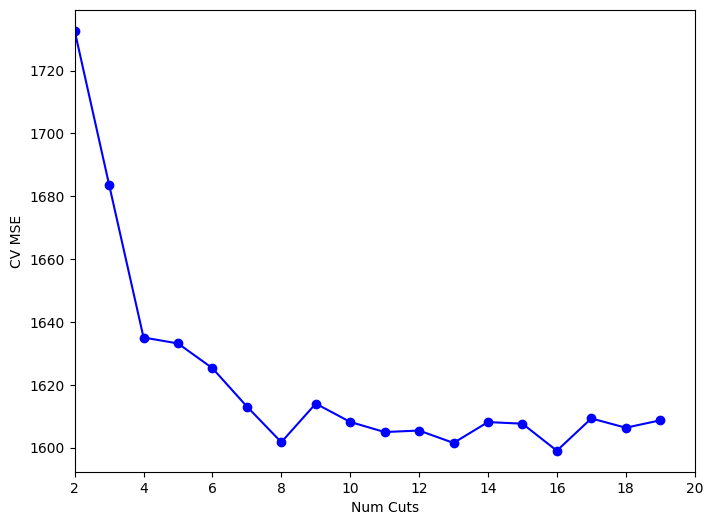

In [183]:
min_mse_idx, min_mse = np.argmin(step_MSEs), np.min(step_MSEs)

fig, axes = plt.subplots(1,1, figsize=(8,6))
axes.plot(np.arange(2,20), np.array(step_MSEs), color='b', marker='o')
axes.set_xlim([2,20]);

axes.set_xlabel('Num Cuts')
axes.set_ylabel('CV MSE')

In this setting, it appears that using `8 cuts` for fitting a step function is a reasonably optimal choice.

In [184]:
# Fit a step function using 8 cuts

age_step, bins = pd.cut(wages.age, 8, retbins=True, right=True)
age_step.value_counts(sort=False)

age
(17.938, 25.75]    231
(25.75, 33.5]      519
(33.5, 41.25]      671
(41.25, 49.0]      728
(49.0, 56.75]      503
(56.75, 64.5]      276
(64.5, 72.25]       54
(72.25, 80.0]       18
Name: count, dtype: int64

In [185]:
# Ensure wages.wage is numeric
if not pd.api.types.is_numeric_dtype(wages.wage):
    wages['wage'] = pd.to_numeric(wages.wage, errors='coerce')  # Convert to numeric, NaNs for invalid values
    print(f"Number of NaNs in wages.wage after conversion: {wages.wage.isna().sum()}")

# Create dummy variables for age_step
age_step_dummies = pd.get_dummies(age_step, drop_first=True)  # drop_first=True removes first category
# Ensure dummy variables are numeric (0/1)
age_step_dummies = age_step_dummies.astype(int)

# Add constant for intercept
age_step_dummies = sm.add_constant(age_step_dummies)

# Fit OLS model
fit = sm.OLS(wages.wage, age_step_dummies).fit()

# Display coefficient table
print(fit.summary().tables[1])

                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
const            76.2818      2.630     29.007      0.000      71.125      81.438
(25.75, 33.5]    25.8333      3.161      8.172      0.000      19.635      32.032
(33.5, 41.25]    40.2257      3.049     13.193      0.000      34.247      46.204
(41.25, 49.0]    43.5011      3.018     14.412      0.000      37.583      49.419
(49.0, 56.75]    40.1358      3.177     12.634      0.000      33.907      46.365
(56.75, 64.5]    44.1024      3.564     12.373      0.000      37.114      51.091
(64.5, 72.25]    28.9482      6.042      4.792      0.000      17.102      40.794
(72.25, 80.0]    15.2242      9.781      1.556      0.120      -3.954      34.403


In [186]:
agelims = np.arange(wages.age.min(), wages.age.max())
age_step_bins = np.digitize(agelims.ravel(), bins)
X_test = pd.get_dummies(age_step_bins).drop(1, axis=1)

In [187]:
# Confidence Intervals
simple_table, data, columns = summary_table(fit, alpha=0.05)
mean_ci_low, mean_ci_upp = data[:, 4:6].T

Text(0, 0.5, 'Wage')

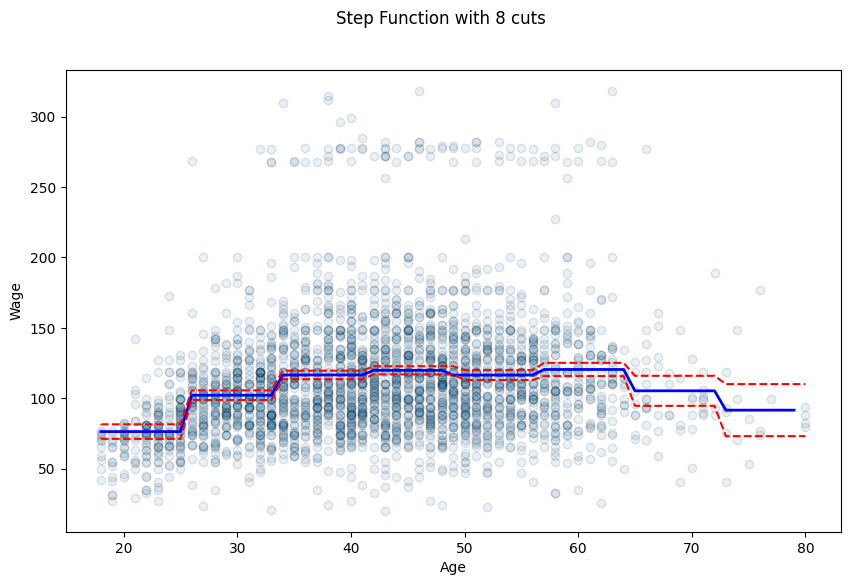

In [188]:
fig, axes = plt.subplots(1, 1, figsize=(10, 6))
fig.suptitle('Step Function with 8 cuts')

axes.scatter(wages.age, wages.wage, facecolors=None, edgecolors='k', alpha=0.1)
axes.plot(agelims, fit.predict(sm.add_constant(X_test)), color='b', lw=2)

idx_order = np.argsort(wages.age.values)
axes.plot(wages.age.values[idx_order], mean_ci_low[idx_order], color='red', linestyle='dashed')
axes.plot(wages.age.values[idx_order], mean_ci_upp[idx_order], color='red', linestyle='dashed')

axes.set_xlabel('Age')
axes.set_ylabel('Wage')

## Question 7

In [189]:
wages.head()

,year,age,maritl,race,education,region,jobclass,health,health_ins,logwage,wage
0,2006,18,1. Never Married,1. White,1. < HS Grad,2. Middle Atlantic,1. Industrial,1. <=Good,2. No,4.318063,75.043154
1,2004,24,1. Never Married,1. White,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,2. No,4.255273,70.476020
2,2003,45,2. Married,1. White,3. Some College,2. Middle Atlantic,1. Industrial,1. <=Good,1. Yes,4.875061,130.982177
3,2003,43,2. Married,3. Asian,4. College Grad,2. Middle Atlantic,2. Information,2. >=Very Good,1. Yes,5.041393,154.685293
4,2005,50,4. Divorced,1. White,2. HS Grad,2. Middle Atlantic,2. Information,1. <=Good,1. Yes,4.318063,75.043154


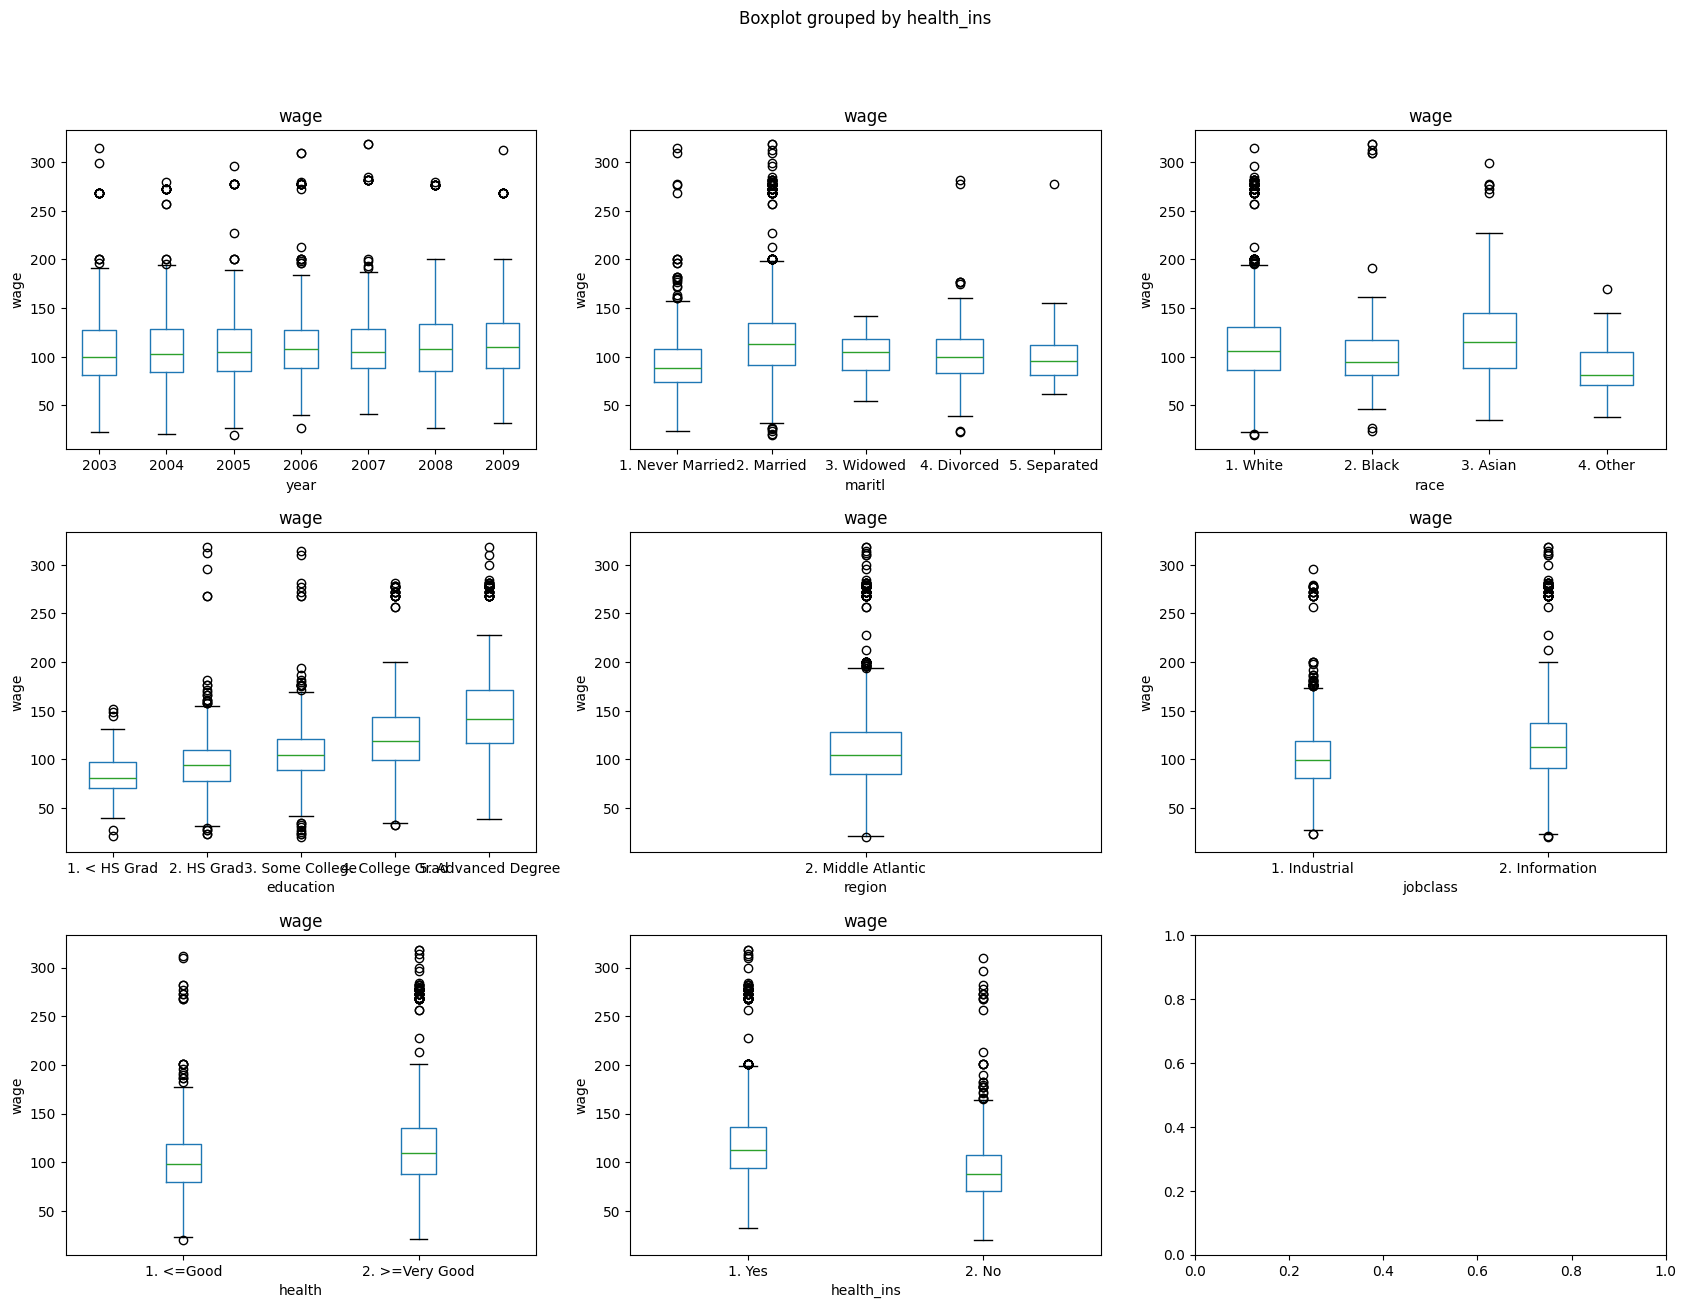

In [190]:
columns = wages.drop(['wage', 'logwage', 'age'], axis=1).columns

fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.tight_layout(pad=5.0)

for idx, predictor in enumerate(columns):
    index = np.unravel_index(idx,(3,3))
    ax = wages.boxplot('wage', by=predictor, ax=axes[index[0], index[1]])
    ax.grid(False)
    axes[index[0], index[1]].set_xlabel(predictor)
    axes[index[0], index[1]].set_ylabel('wage')

Based on the provided figure, we can select `year`, `age`, `education`, and `health_ins` as predictors to construct a generalized additive model. 

In [191]:
df = dmatrix("cr(year, df=4, constraints='center') + cr(age, df=5, constraints='center') + education + health_ins",
            data=wages, return_type='dataframe')

df.head(2)

,Intercept,education[T.2. HS Grad],education[T.3. Some College],education[T.4. College Grad],education[T.5. Advanced Degree],health_ins[T.2. No],"cr(year, df=4, constraints='center')[0]","cr(year, df=4, constraints='center')[1]","cr(year, df=4, constraints='center')[2]","cr(year, df=4, constraints='center')[3]","cr(age, df=5, constraints='center')[0]","cr(age, df=5, constraints='center')[1]","cr(age, df=5, constraints='center')[2]","cr(age, df=5, constraints='center')[3]","cr(age, df=5, constraints='center')[4]"
0,1.0,0.0,0.0,0.0,0.0,1.0,-0.163729,0.875408,-0.134574,-0.098130,-0.501258,-0.695111,-0.500457,-0.097924,-0.005629
1,1.0,0.0,0.0,1.0,0.0,1.0,0.589322,-0.388702,-0.208715,-0.187743,0.400144,-0.615868,-0.284361,-0.074217,-0.002268


In [192]:
gam = sm.OLS(wages.wage, df).fit()
gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   wage   R-squared:                       0.325
Model:                            OLS   Adj. R-squared:                  0.322
Method:                 Least Squares   F-statistic:                     102.8
Date:                Wed, 09 Jul 2025   Prob (F-statistic):          1.81e-242
Time:                        13:50:45   Log-Likelihood:                -14860.
No. Observations:                3000   AIC:                         2.975e+04
Df Residuals:                    2985   BIC:                         2.984e+04
Df Model:                          14                                         
Covariance Type:            nonrobust                                         
===========================================================================================================
                                              coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------------------------
Intercept                                  94.3414      2.233     42.253      0.000      89.963      98.719
education[T.2. HS Grad]                     8.2388      2.385      3.454      0.001       3.562      12.916
education[T.3. Some College]               19.2102      2.528      7.599      0.000      14.253      24.167
education[T.4. College Grad]               33.3565      2.521     13.229      0.000      28.413      38.300
education[T.5. Advanced Degree]            57.0334      2.737     20.841      0.000      51.668      62.399
health_ins[T.2. No]                       -16.9523      1.421    -11.932      0.000     -19.738     -14.167
cr(year, df=4, constraints='center')[0]    -0.1867      1.505     -0.124      0.901      -3.138       2.765
cr(year, df=4, constraints='center')[1]     3.3680      1.469      2.292      0.022       0.487       6.249
cr(year, df=4, constraints='center')[2]     2.6871      1.530      1.757      0.079      -0.312       5.686
cr(year, df=4, constraints='center')[3]     4.5473      1.674      2.717      0.007       1.266       7.829
cr(age, df=5, constraints='center')[0]      5.4517      2.586      2.108      0.035       0.380      10.523
cr(age, df=5, constraints='center')[1]     26.1242      2.660      9.822      0.000      20.909      31.340
cr(age, df=5, constraints='center')[2]     16.6963      2.457      6.795      0.000      11.878      21.514
cr(age, df=5, constraints='center')[3]      5.0031      2.802      1.785      0.074      -0.492      10.498
cr(age, df=5, constraints='center')[4]    -26.0040     11.041     -2.355      0.019     -47.653      -4.355
==============================================================================
Omnibus:                     1141.073   Durbin-Watson:                   1.974
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6646.748
Skew:                           1.701   Prob(JB):                         0.00
Kurtosis:                       9.450   Cond. No.                         20.4
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [193]:
edu_basis = df.iloc[:, 1:5]
healthins_basis = df.iloc[:, 5]
year_basis = df.iloc[:, 6: 10]
age_basis = df.iloc[:, 10:]

C:\Users\admin\AppData\Local\Temp\ipykernel_7592\529167452.py:21: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  wages['healthins_basis'] = np.dot(healthins_basis.values, gam.params[5])


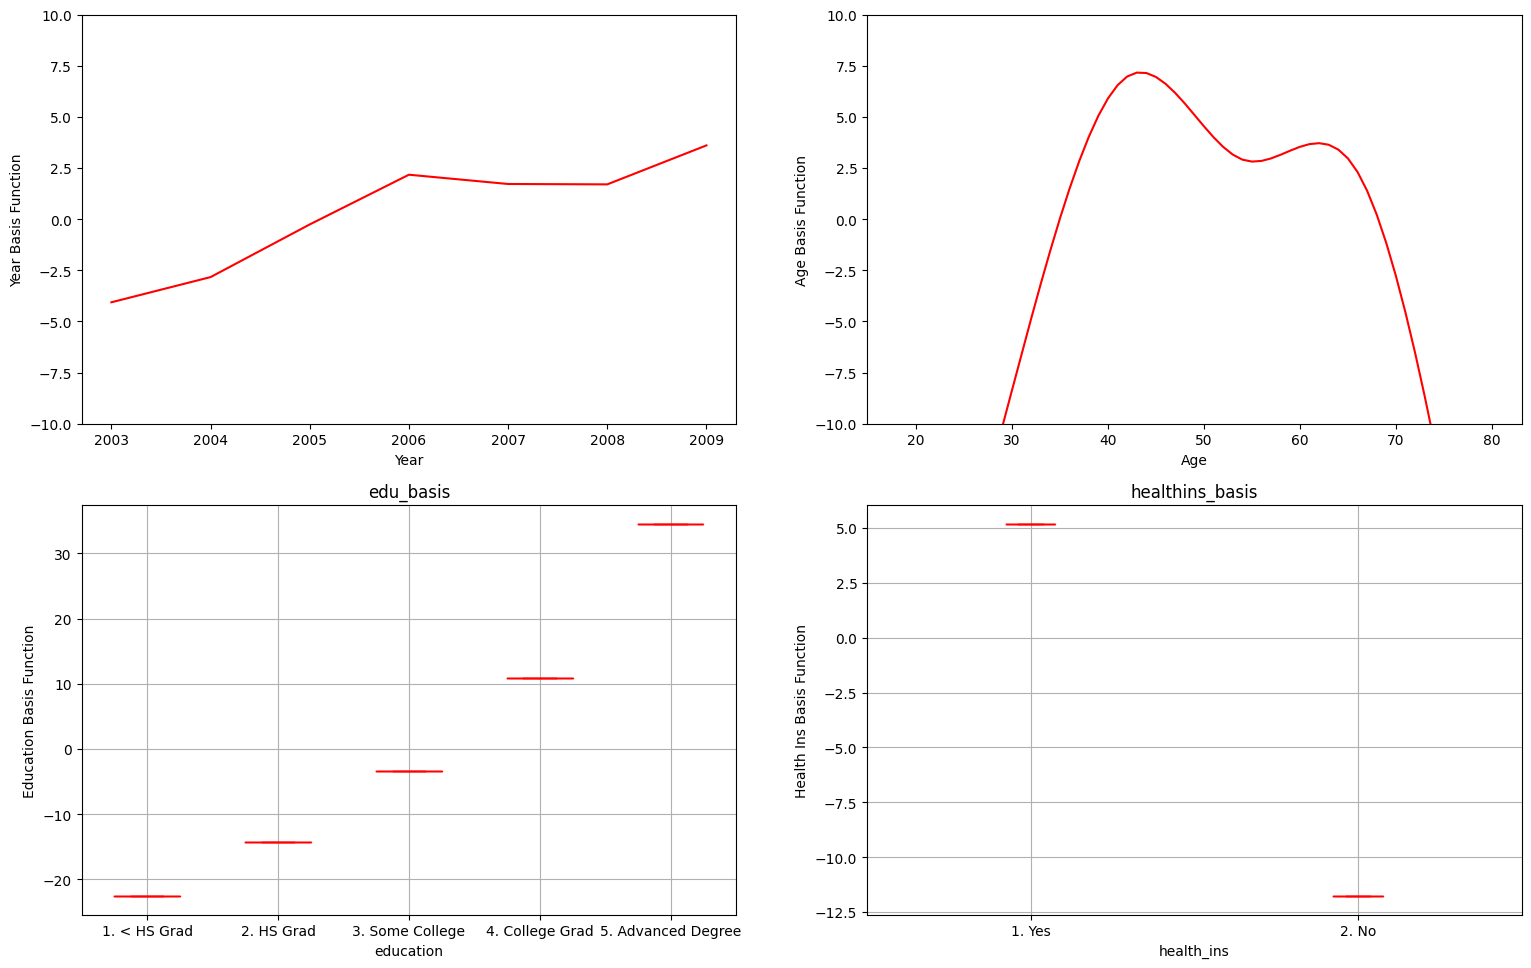

In [194]:
fig, axes = plt.subplots(2, 2, figsize=(18, 12))

year_order = np.argsort(wages.year.values)
axes[0, 0].plot(wages.year[year_order], np.dot(year_basis.values, gam.params[6:10])[year_order], color='r')
axes[0, 0].set_xlabel('Year')
axes[0, 0].set_ylabel('Year Basis Function')
axes[0, 0].set_ylim([-10, 10])

age_order = np.argsort(wages.age.values)
axes[0, 1].plot(wages.age[age_order], np.dot(age_basis.values, gam.params[10:])[age_order], color='r')
axes[0, 1].set_xlabel('Age')
axes[0, 1].set_ylabel('Age Basis Function')
axes[0, 1].set_ylim([-10, 10])

wages['edu_basis'] = np.dot(edu_basis.values, gam.params[1:5])
wages['edu_basis'] -= wages['edu_basis'].mean()
wages.boxplot(column='edu_basis', by='education', ax=axes[1, 0], color='r')
axes[1, 0].set_ylabel('Education Basis Function');
plt.suptitle('');

wages['healthins_basis'] = np.dot(healthins_basis.values, gam.params[5])
wages['healthins_basis'] -= wages['healthins_basis'].mean()
wages.boxplot(column='healthins_basis', by='health_ins', ax=axes[1, 1], color='r')
axes[1, 1].set_ylabel('Health Ins Basis Function');
plt.suptitle('');

In order to predict wage data with `year`, `age`, `education`, and `health_ins` as predictors. When we construct a generalized additive model with using this values as predictors, we fit the model by using different smoothing functions for each predictors. 

In [195]:
gam.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,94.3414,2.233,42.253,0.000,89.963,98.719
education[T.2. HS Grad],8.2388,2.385,3.454,0.001,3.562,12.916
education[T.3. Some College],19.2102,2.528,7.599,0.000,14.253,24.167
education[T.4. College Grad],33.3565,2.521,13.229,0.000,28.413,38.300
education[T.5. Advanced Degree],57.0334,2.737,20.841,0.000,51.668,62.399
health_ins[T.2. No],-16.9523,1.421,-11.932,0.000,-19.738,-14.167
"cr(year, df=4, constraints='center')[0]",-0.1867,1.505,-0.124,0.901,-3.138,2.765
"cr(year, df=4, constraints='center')[1]",3.3680,1.469,2.292,0.022,0.487,6.249
"cr(year, df=4, constraints='center')[2]",2.6871,1.530,1.757,0.079,-0.312,5.686
"cr(year, df=4, constraints='center')[3]",4.5473,1.674,2.717,0.007,1.266,7.829


In the lab section, we constructed another GAM model without including the `health_ins` predictor. However, upon examining the result table of the GAM model, it becomes apparent that `health_ins` is a significant predictor for predicting wage data. This observation can also be supported by conducting ANOVA hypothesis testing.

In [196]:
# Gam model without health_ins predictor

df2 = dmatrix("cr(year, df=4, constraints='center') + cr(age, df=5, constraints='center') + education",
             data=wages, return_type='dataframe')

df2.head(2)

,Intercept,education[T.2. HS Grad],education[T.3. Some College],education[T.4. College Grad],education[T.5. Advanced Degree],"cr(year, df=4, constraints='center')[0]","cr(year, df=4, constraints='center')[1]","cr(year, df=4, constraints='center')[2]","cr(year, df=4, constraints='center')[3]","cr(age, df=5, constraints='center')[0]","cr(age, df=5, constraints='center')[1]","cr(age, df=5, constraints='center')[2]","cr(age, df=5, constraints='center')[3]","cr(age, df=5, constraints='center')[4]"
0,1.0,0.0,0.0,0.0,0.0,-0.163729,0.875408,-0.134574,-0.098130,-0.501258,-0.695111,-0.500457,-0.097924,-0.005629
1,1.0,0.0,0.0,1.0,0.0,0.589322,-0.388702,-0.208715,-0.187743,0.400144,-0.615868,-0.284361,-0.074217,-0.002268


In [197]:
gam2 = sm.OLS(wages.wage, df2).fit()
gam2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,85.4759,2.155,39.668,0.000,81.251,89.701
education[T.2. HS Grad],10.9574,2.430,4.509,0.000,6.193,15.722
education[T.3. Some College],23.4431,2.562,9.152,0.000,18.420,28.466
education[T.4. College Grad],38.2330,2.546,15.015,0.000,33.240,43.226
education[T.5. Advanced Degree],62.4786,2.761,22.626,0.000,57.064,67.893
"cr(year, df=4, constraints='center')[0]",-0.0548,1.540,-0.036,0.972,-3.075,2.965
"cr(year, df=4, constraints='center')[1]",3.6194,1.504,2.407,0.016,0.671,6.567
"cr(year, df=4, constraints='center')[2]",2.2938,1.565,1.466,0.143,-0.775,5.363
"cr(year, df=4, constraints='center')[3]",4.5342,1.713,2.647,0.008,1.176,7.893
"cr(age, df=5, constraints='center')[0]",7.7241,2.640,2.926,0.003,2.548,12.900


In [198]:
table = sm.stats.anova_lm(gam2, gam)
table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2986.0,3.691628e+06,0.0,NaN,NaN,NaN
1,2985.0,3.523567e+06,1.0,168061.164689,142.373497,4.275155e-32


Once again, the ANOVA results confirm that the `health_ins` variable is a significant predictor in this model.

In [199]:
# Now we can do the same process for other categorical datas, such as marit1


df3 = dmatrix("cr(year, df=4, constraints='center') + cr(age, df=5, constraints='center') + education + health_ins + maritl",
             data=wages, return_type='dataframe')

df3.head(2)

,Intercept,education[T.2. HS Grad],education[T.3. Some College],education[T.4. College Grad],education[T.5. Advanced Degree],health_ins[T.2. No],maritl[T.2. Married],maritl[T.3. Widowed],maritl[T.4. Divorced],maritl[T.5. Separated],"cr(year, df=4, constraints='center')[0]","cr(year, df=4, constraints='center')[1]","cr(year, df=4, constraints='center')[2]","cr(year, df=4, constraints='center')[3]","cr(age, df=5, constraints='center')[0]","cr(age, df=5, constraints='center')[1]","cr(age, df=5, constraints='center')[2]","cr(age, df=5, constraints='center')[3]","cr(age, df=5, constraints='center')[4]"
0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,-0.163729,0.875408,-0.134574,-0.098130,-0.501258,-0.695111,-0.500457,-0.097924,-0.005629
1,1.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.589322,-0.388702,-0.208715,-0.187743,0.400144,-0.615868,-0.284361,-0.074217,-0.002268


In [200]:
gam3 = sm.OLS(wages.wage, df3).fit()
gam3.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
Intercept,84.4409,2.628,32.127,0.000,79.287,89.594
education[T.2. HS Grad],8.3134,2.358,3.525,0.000,3.690,12.937
education[T.3. Some College],19.5190,2.501,7.806,0.000,14.616,24.422
education[T.4. College Grad],33.3447,2.495,13.366,0.000,28.453,38.236
education[T.5. Advanced Degree],56.4182,2.712,20.806,0.000,51.101,61.735
health_ins[T.2. No],-17.1743,1.402,-12.251,0.000,-19.923,-14.426
maritl[T.2. Married],14.1618,1.812,7.818,0.000,10.610,17.714
maritl[T.3. Widowed],-0.4820,7.993,-0.060,0.952,-16.153,15.189
maritl[T.4. Divorced],0.4619,2.936,0.157,0.875,-5.295,6.219
maritl[T.5. Separated],8.1012,4.872,1.663,0.096,-1.452,17.655


In [201]:
table = sm.stats.anova_lm(gam2, gam, gam3)
table

,df_resid,ssr,df_diff,ss_diff,F,Pr(>F)
0,2986.0,3.691628e+06,0.0,NaN,NaN,NaN
1,2985.0,3.523567e+06,1.0,168061.164689,146.283842,6.538230e-33
2,2981.0,3.424782e+06,4.0,98784.723030,21.496056,1.676030e-17


## Question 8

In [202]:
auto = pd.read_csv('../../data/auto.csv')
auto.drop(['name'], axis=1, inplace=True)
auto.head()

,mpg,cylinders,displacement,horsepower,weight,acceleration,year,origin
0,18.0,8,307.0,130,3504,12.0,70,1
1,15.0,8,350.0,165,3693,11.5,70,1
2,18.0,8,318.0,150,3436,11.0,70,1
3,16.0,8,304.0,150,3433,12.0,70,1
4,17.0,8,302.0,140,3449,10.5,70,1


Let's try to predict `mpg` by using the other variables as predictors.

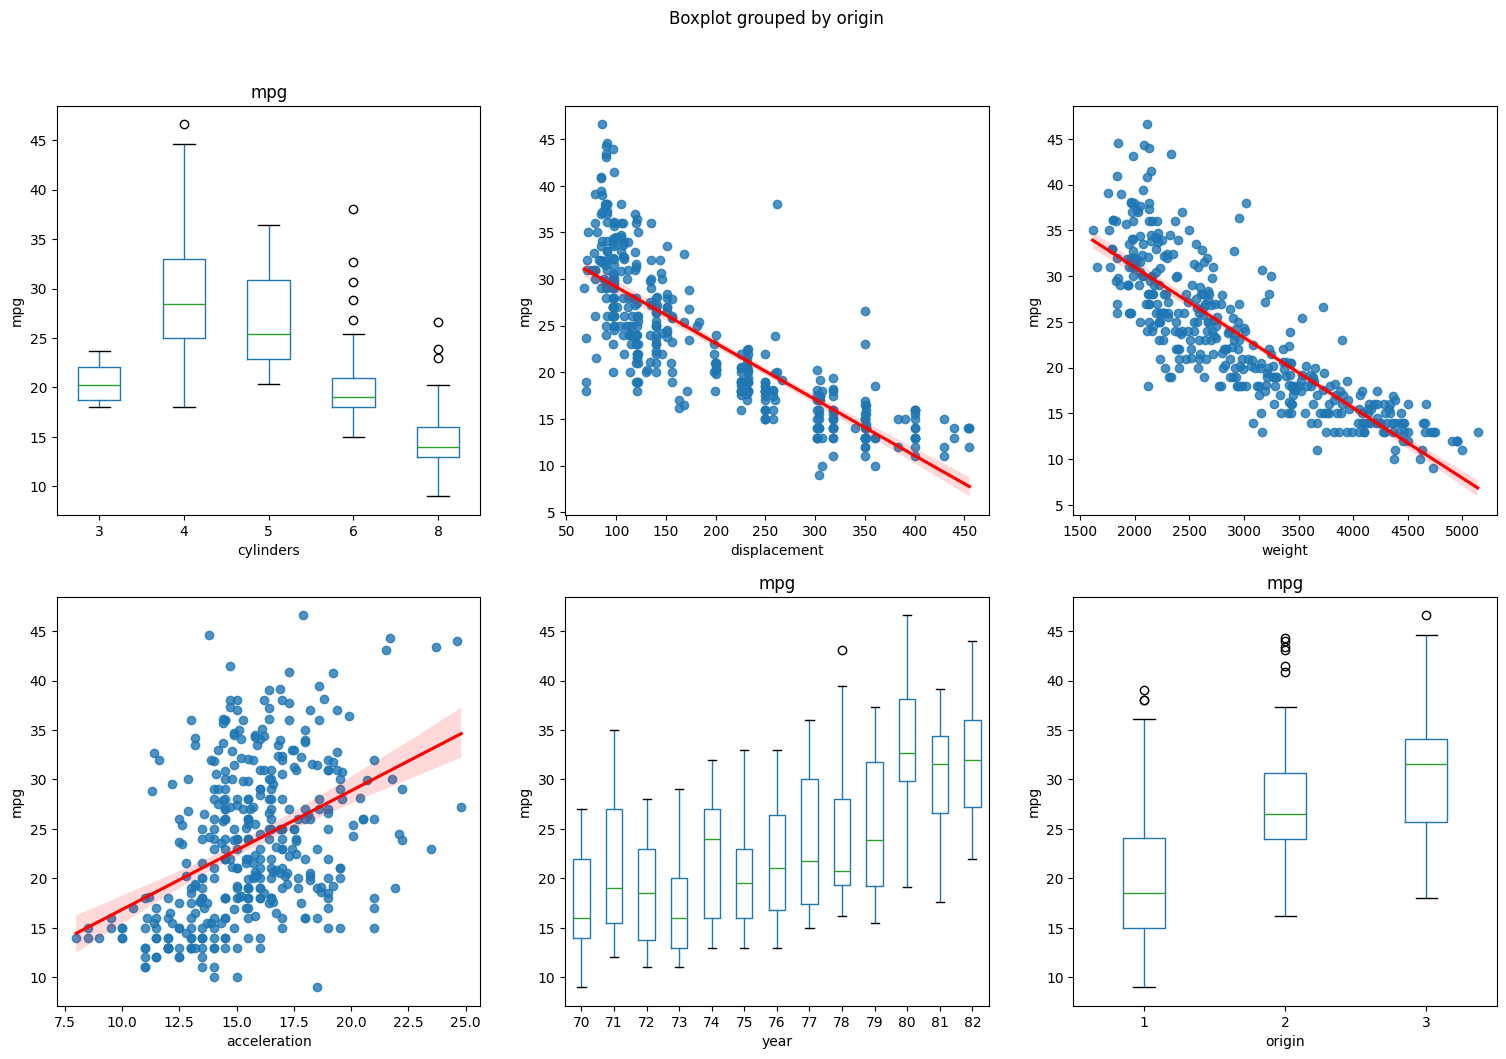

In [203]:
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

predictors = auto.drop(['horsepower'], axis=1).columns[1:]

for idx, predictor in enumerate(predictors):
    index = np.unravel_index(idx,(2,3))
    if predictor == 'horsepower':
        continue
    if predictor in ['displacement', 'acceleration', 'weight']:
        ax = sns.regplot(x=predictor, y='mpg', data=auto, ax=axes[index[0], index[1]], line_kws={"color": "red"})
    else:
        ax = auto.boxplot(column='mpg', by=predictor, ax=axes[index[0], index[1]])
    ax.set_xlabel(predictor)
    ax.set_ylabel('mpg')
    ax.grid(False)

Based on the provided figure, we can observe the following relationships:
- The variables `displacement` and `weight` exhibit a non-linear relationship with `mpg` data.

- The variable `acceleration` shows a weak relationship with `mpg`.

- The variables `cylinders`, `year`, and `origin` appear to be strong predictors for predicting `mpg`.

Based on these observations, we can construct a Generalized Additive Model (GAM) using these predictors to predict the `mpg` data.

In [204]:
# Cross-validation to determine the appropriate degrees of freedom for `displacement`, `weight`, and `acceleration`

scores = []
for df in range(2, 10):
    cv_basis = dmatrix(f"1 + cr(displacement, df={df}, constraints='center')", 
                       data={'displacement': auto.displacement}, return_type='dataframe')
    
    scores.append(-np.mean(cross_val_score(LinearRegression(fit_intercept=True), cv_basis, auto.mpg,
                                           cv=5, scoring='neg_mean_squared_error')))    

Text(0, 0.5, 'CV MSE')

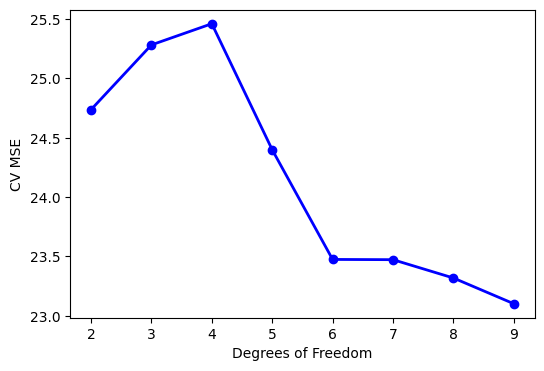

In [205]:
# Build CV Error plot
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(np.arange(2,10), scores, lw=2, color='b', marker='o')
ax.set_xlabel('Degrees of Freedom')
ax.set_ylabel('CV MSE')

We can use a 6 degrees of freedom to construct a natural cubic spline for `displacement` variable

Text(0, 0.5, 'CV MSE')

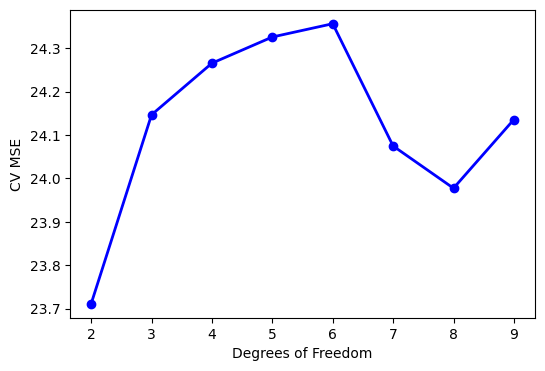

In [206]:
scores = []
for df in range(2, 10):
    cv_basis = dmatrix(f"1 + cr(weight, df={df}, constraints='center')", 
                       data={'weight': auto.weight}, return_type='dataframe')
    
    scores.append(-np.mean(cross_val_score(LinearRegression(fit_intercept=True), cv_basis, auto.mpg,
                                           cv=5, scoring='neg_mean_squared_error')))    
    
# Build CV Error plot
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(np.arange(2,10), scores, lw=2, color='b', marker='o')
ax.set_xlabel('Degrees of Freedom')
ax.set_ylabel('CV MSE')

For the `weight` predictor 2 degrees of freedom provide best fit in this settings.

Text(0, 0.5, 'CV MSE')

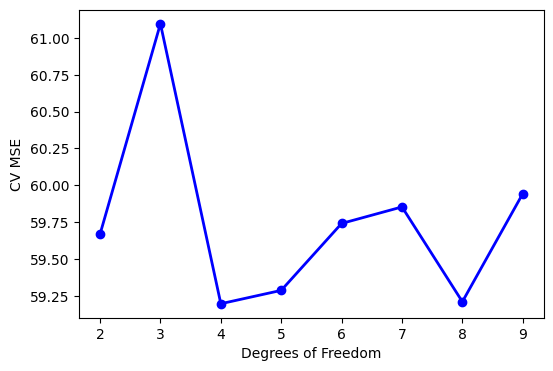

In [207]:
scores = []
for df in range(2, 10):
    cv_basis = dmatrix(f"1 + cr(acceleration, df={df}, constraints='center')", 
                       data={'acceleration': auto.acceleration}, return_type='dataframe')
    
    scores.append(-np.mean(cross_val_score(LinearRegression(fit_intercept=True), cv_basis, auto.mpg,
                                           cv=5, scoring='neg_mean_squared_error')))    
    
# Build CV Error plot
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(np.arange(2,10), scores, lw=2, color='b', marker='o')
ax.set_xlabel('Degrees of Freedom')
ax.set_ylabel('CV MSE')

For the `acceleration` predictor 4 degrees of freedom provide best fit in this settings.

In [208]:
# Building a GAM to predict `mpg`

df = dmatrix("""cr(displacement, df=6, constraints='center') + cr(weight, df=2, constraints='center') + 
cr(acceleration, df=4, constraints='center') + year + cylinders + origin""", data=auto, return_type='dataframe')

df.head(2)

,Intercept,"cr(displacement, df=6, constraints='center')[0]","cr(displacement, df=6, constraints='center')[1]","cr(displacement, df=6, constraints='center')[2]","cr(displacement, df=6, constraints='center')[3]","cr(displacement, df=6, constraints='center')[4]","cr(displacement, df=6, constraints='center')[5]","cr(weight, df=2, constraints='center')[0]","cr(weight, df=2, constraints='center')[1]","cr(acceleration, df=4, constraints='center')[0]","cr(acceleration, df=4, constraints='center')[1]","cr(acceleration, df=4, constraints='center')[2]","cr(acceleration, df=4, constraints='center')[3]",year,cylinders,origin
0,1.0,-0.250294,-0.285900,-0.091344,-0.271890,0.621235,-0.064743,0.391162,0.057323,0.650275,-0.849892,-0.258573,-0.035162,70.0,8.0,1.0
1,1.0,-0.164505,-0.359046,0.188037,-0.561554,0.674847,0.135808,0.389002,0.138752,0.584519,-0.908556,-0.264232,-0.036804,70.0,8.0,1.0


In [209]:
gam_auto = sm.OLS(auto.mpg, df).fit()
gam_auto.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    mpg   R-squared:                       0.867
Model:                            OLS   Adj. R-squared:                  0.861
Method:                 Least Squares   F-statistic:                     164.9
Date:                Wed, 09 Jul 2025   Prob (F-statistic):          3.82e-156
Time:                        13:50:47   Log-Likelihood:                -979.85
No. Observations:                 397   AIC:                             1992.
Df Residuals:                     381   BIC:                             2055.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
===================================================================================================================
                                                      coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------------
Intercept                                         -39.5959      4.013     -9.868      0.000     -47.485     -31.706
cr(displacement, df=6, constraints='center')[0]     1.6852      0.794      2.123      0.034       0.125       3.246
cr(displacement, df=6, constraints='center')[1]     1.2770      0.653      1.956      0.051      -0.006       2.560
cr(displacement, df=6, constraints='center')[2]     0.2511      0.534      0.470      0.639      -0.799       1.302
cr(displacement, df=6, constraints='center')[3]     0.6368      0.845      0.753      0.452      -1.025       2.299
cr(displacement, df=6, constraints='center')[4]     1.0303      1.908      0.540      0.590      -2.721       4.782
cr(displacement, df=6, constraints='center')[5]    -0.2654      2.054     -0.129      0.897      -4.304       3.773
cr(weight, df=2, constraints='center')[0]         -10.1917      1.125     -9.057      0.000     -12.404      -7.979
cr(weight, df=2, constraints='center')[1]          -8.8498      1.534     -5.768      0.000     -11.867      -5.833
cr(acceleration, df=4, constraints='center')[0]    -2.5965      1.294     -2.006      0.046      -5.141      -0.052
cr(acceleration, df=4, constraints='center')[1]    -1.9312      0.984     -1.962      0.050      -3.866       0.004
cr(acceleration, df=4, constraints='center')[2]    -1.3491      0.896     -1.506      0.133      -3.110       0.412
cr(acceleration, df=4, constraints='center')[3]     5.2915      1.486      3.561      0.000       2.370       8.213
year                                                0.8260      0.045     18.248      0.000       0.737       0.915
cylinders                                          -0.0931      0.387     -0.241      0.810      -0.854       0.668
origin                                              0.5400      0.267      2.025      0.044       0.016       1.064
==============================================================================
Omnibus:                       40.914   Durbin-Watson:                   1.433
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.043
Skew:                           0.563   Prob(JB):                     1.26e-19
Kurtosis:                       4.999   Cond. No.                     2.15e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.15e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

## Question 9

In [210]:
boston = pd.read_csv('../../data/boston.csv')
boston.drop(boston.columns[0], axis=1, inplace=True)
boston.head()

,crim,zn,indus,chas,nox,rm,age,dis,rad,tax,ptratio,lstat,medv
0,0.00632,18.0,2.31,0,0.538,6.575,65.2,4.0900,1,296,15.3,4.98,24.0
1,0.02731,0.0,7.07,0,0.469,6.421,78.9,4.9671,2,242,17.8,9.14,21.6
2,0.02729,0.0,7.07,0,0.469,7.185,61.1,4.9671,2,242,17.8,4.03,34.7
3,0.03237,0.0,2.18,0,0.458,6.998,45.8,6.0622,3,222,18.7,2.94,33.4
4,0.06905,0.0,2.18,0,0.458,7.147,54.2,6.0622,3,222,18.7,5.33,36.2


### 9.a

In [211]:
poly = PolynomialFeatures(3)
dis_poly = poly.fit_transform(boston.dis.values.reshape(-1, 1))

model = sm.OLS(boston.nox, sm.add_constant(dis_poly)).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                    nox   R-squared:                       0.715
Model:                            OLS   Adj. R-squared:                  0.713
Method:                 Least Squares   F-statistic:                     419.3
Date:                Wed, 09 Jul 2025   Prob (F-statistic):          2.71e-136
Time:                        13:50:47   Log-Likelihood:                 690.44
No. Observations:                 506   AIC:                            -1373.
Df Residuals:                     502   BIC:                            -1356.
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.9341      0.021     45.110      0.000       0.893       0.975
x1            -0.1821      0.015    -12.389      0.000      -0.211      -0.153
x2             0.0219      0.003      7.476      0.000       0.016       0.028
x3            -0.0009      0.000     -5.124      0.000      -0.001      -0.001
==============================================================================
Omnibus:                       64.176   Durbin-Watson:                   0.286
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               87.386
Skew:                           0.917   Prob(JB):                     1.06e-19
Kurtosis:                       3.886   Cond. No.                     2.10e+03
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 2.1e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'nox')

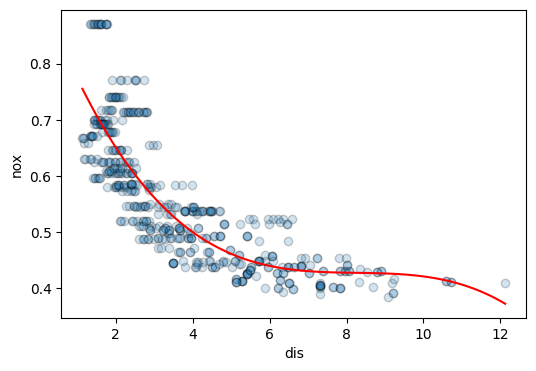

In [212]:
dislims = np.linspace(boston.dis.min(), boston.dis.max(), 100)
X_test = poly.transform(dislims.reshape(-1, 1))
pred = model.predict(sm.add_constant(X_test))

fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.scatter(boston.dis, boston.nox, facecolors=None, edgecolors='k', alpha=0.2)
ax.plot(dislims, pred, color='r')
ax.set_xlabel('dis')
ax.set_ylabel('nox')

### 9.b

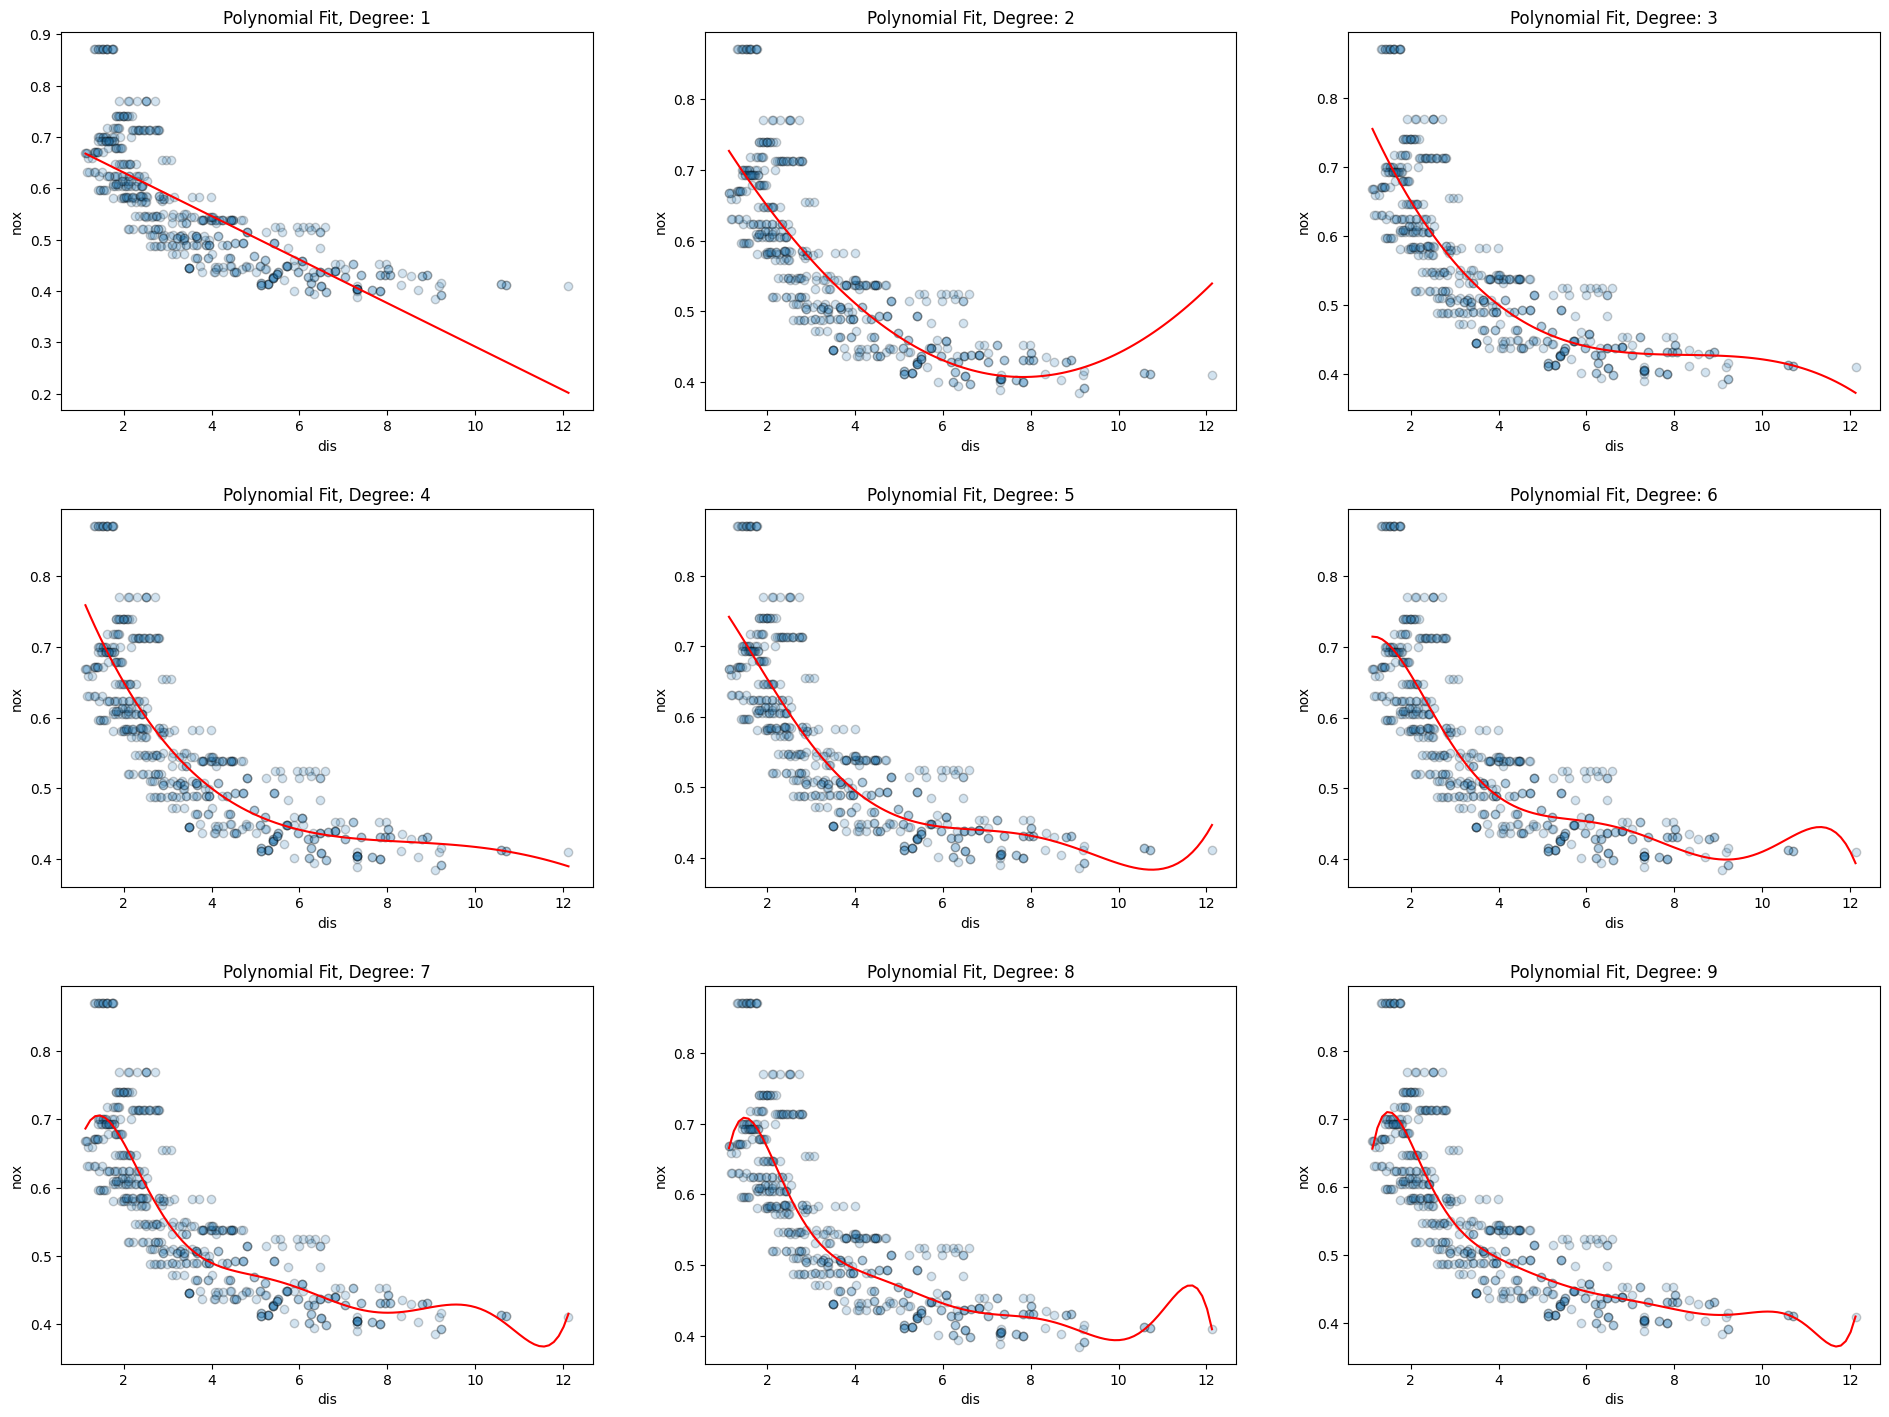

In [213]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.tight_layout(pad=5.0)

dislims = np.linspace(boston.dis.min(), boston.dis.max(), 100)

for idx, degree in enumerate(np.arange(1, 10)):
    index = np.unravel_index(idx,(3,3))
    
    poly = PolynomialFeatures(degree)
    dis_poly = poly.fit_transform(boston.dis.values.reshape(-1, 1))

    model = sm.OLS(boston.nox, sm.add_constant(dis_poly)).fit()
    X_test = poly.transform(dislims.reshape(-1, 1))
    pred = model.predict(sm.add_constant(X_test))
    
    axes[index[0], index[1]].scatter(boston.dis, boston.nox, facecolors=None, edgecolors='k', alpha=0.2)
    axes[index[0], index[1]].plot(dislims, pred, color='r')
    axes[index[0], index[1]].set_xlabel('dis')
    axes[index[0], index[1]].set_ylabel('nox')
    axes[index[0], index[1]].set_title(f'Polynomial Fit, Degree: {degree}')

### 9.c

Text(0, 0.5, 'CV Error')

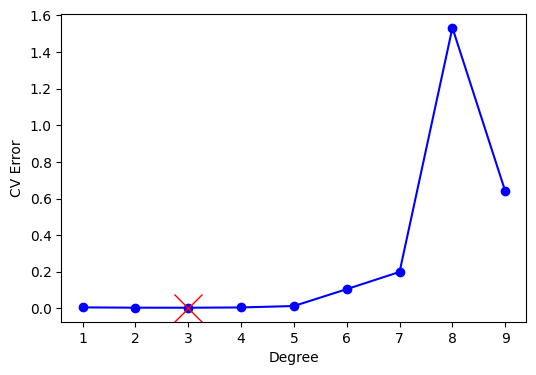

In [214]:
scores = []

for i in np.arange(1, 10):
    poly = PolynomialFeatures(i)
    dis_poly = poly.fit_transform(boston.dis.values.reshape(-1, 1))

    lm = LinearRegression(fit_intercept=True)
    scores.append(-np.mean(cross_val_score(lm, dis_poly, boston.nox, 
                                           cv=10, scoring='neg_mean_squared_error')))
    
fig,ax = plt.subplots(1,1, figsize=(6,4))
ax.plot(np.arange(1, 10), scores, color='b', marker='o')
ax.plot(np.argmin(scores)+1, np.min(scores), marker='x', color='r', markersize=20)
ax.set_xlabel('Degree')
ax.set_ylabel('CV Error')

### 9.d

In [215]:
dislims = np.linspace(boston.dis.min(), boston.dis.max(), 200)

In [216]:
dis_spline = dmatrix('bs(dis, df=4, include_intercept=False)', data=boston, return_type='dataframe')
dislims_spline = dmatrix('bs(dislims, df=4, include_intercept=False)', {'dislims': dislims}, return_type='dataframe')

In [217]:
spline_model = sm.OLS(boston.nox, dis_spline).fit()
pred = spline_model.predict(dislims_spline)

Text(0, 0.5, 'Nox')

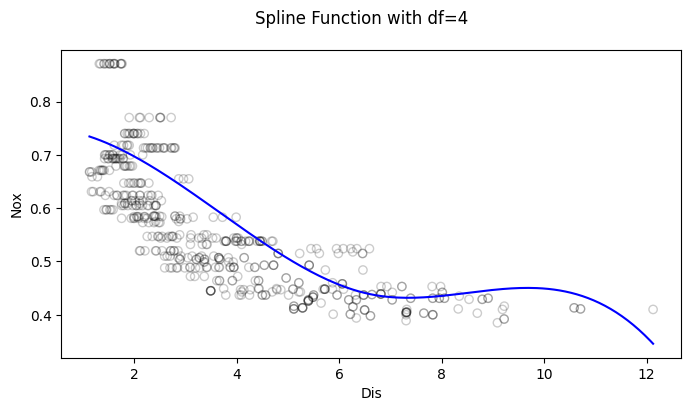

In [218]:
fig, axes = plt.subplots(1,1, figsize=(8,4))
fig.suptitle('Spline Function with df=4')

axes.scatter(boston.dis, boston.nox, facecolors='None', edgecolors='k', alpha=0.2)
axes.plot(dislims, pred, color='b')

axes.set_xlabel('Dis')
axes.set_ylabel('Nox')

### 9.e

Text(0, 0.5, 'CV Error')

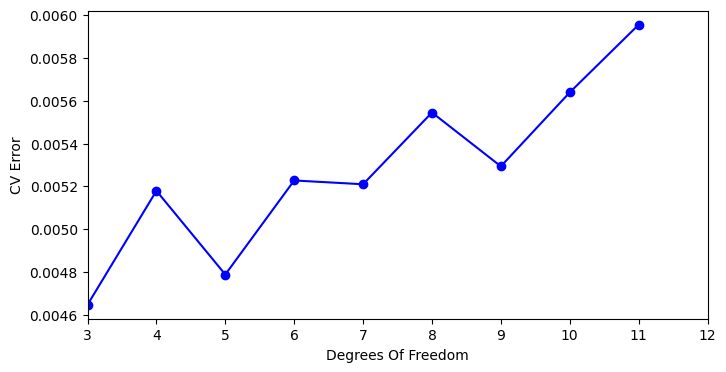

In [219]:
scores = []
for i in np.arange(3, 12):
    dis_spline = dmatrix(f'bs(dis, df={i}, include_intercept=False)', data=boston, return_type='dataframe')

    lm = LinearRegression(fit_intercept=True)
    scores.append(-np.mean(cross_val_score(lm, dis_spline, boston.nox, cv=5,
                                         scoring='neg_mean_squared_error')))

fig, axes = plt.subplots(1,1, figsize=(8,4))
axes.plot(np.arange(3, 12), scores, color='b', marker='o')
axes.set_xlim([3,12]);
axes.set_xlabel('Degrees Of Freedom')
axes.set_ylabel('CV Error')

Based on the cross-validation scores, a 3 degrees of freedom gives the optimum results.

## Question 10

### 10.a

In [220]:
college = pd.read_csv('../../data/college.csv')
college.drop(college.columns[0], axis=1, inplace=True)
college.head()

,Private,Apps,Accept,Enroll,Top10perc,Top25perc,F.Undergrad,P.Undergrad,Outstate,Room.Board,Books,Personal,PhD,Terminal,S.F.Ratio,perc.alumni,Expend,Grad.Rate
0,Yes,1660,1232,721,23,52,2885,537,7440,3300,450,2200,70,78,18.1,12,7041,60
1,Yes,2186,1924,512,16,29,2683,1227,12280,6450,750,1500,29,30,12.2,16,10527,56
2,Yes,1428,1097,336,22,50,1036,99,11250,3750,400,1165,53,66,12.9,30,8735,54
3,Yes,417,349,137,60,89,510,63,12960,5450,450,875,92,97,7.7,37,19016,59
4,Yes,193,146,55,16,44,249,869,7560,4120,800,1500,76,72,11.9,2,10922,15


In [221]:
college['Private'] = pd.get_dummies(college['Private'])['Yes']

X = college.drop(['Outstate'], axis=1)
y = college.Outstate

In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.4, random_state=11)

In [223]:
def forward_stepwise(X, y, max_features):
    # Preprocess X and y to ensure numeric data
    X = X.copy()  # Avoid modifying original data
    y = y.copy()
    
    # Convert categorical columns in X to dummies
    categorical_cols = X.select_dtypes(include=['object', 'category']).columns
    if len(categorical_cols) > 0:
        print(f"Converting categorical columns to dummies: {list(categorical_cols)}")
        X = pd.get_dummies(X, columns=categorical_cols, drop_first=True).astype(float)
    
    # Ensure all columns in X are numeric
    for col in X.columns:
        if not pd.api.types.is_numeric_dtype(X[col]):
            print(f"Converting {col} to numeric")
            X[col] = pd.to_numeric(X[col], errors='coerce')
    
    # Ensure y is numeric
    if not pd.api.types.is_numeric_dtype(y):
        print("Converting y to numeric")
        y = pd.to_numeric(y, errors='coerce')
    
    # Align indices and drop NaNs
    valid_idx = X.index.intersection(y.index)
    valid_idx = valid_idx[~X.loc[valid_idx].isna().any(axis=1) & ~y.loc[valid_idx].isna()]
    X = X.loc[valid_idx]
    y = y.loc[valid_idx]
    print(f"Data shape after preprocessing: X={X.shape}, y={y.shape}")

    def process_linear_model(subset, data, response):
        x_train = sm.add_constant(data[subset])
        model = sm.OLS(response, x_train).fit()
        train_RSS = mean_squared_error(response, model.predict(sm.add_constant(x_train)))
        return (model, train_RSS)
    
    def update_model(current_features, remaining_features):
        best_rss = np.inf
        best_model = None
        new_feature_list = current_features[:]
        
        for new_feature in tqdm(remaining_features):
            result = process_linear_model(current_features + [new_feature], X, y)
            if result[1] < best_rss:
                best_rss = result[1]
                new_feature_list = current_features + [new_feature]
                best_model = result[0]
        
        return new_feature_list, best_model
    
    feature_list = []
    models = []
    remaining_features = list(X.columns)
    
    while remaining_features and len(feature_list) < max_features:
        feature_list, best_model = update_model(feature_list, remaining_features)
        remaining_features = [x for x in list(X.columns) if x not in feature_list]
        models.append([feature_list, best_model])
    
    return models

In [224]:
# Ensure all columns in X_train are numeric before passing to forward_stepwise
X_train_clean = X_train.copy()

# Convert boolean columns to int
for col in X_train_clean.select_dtypes(include=['bool']).columns:
	X_train_clean[col] = X_train_clean[col].astype(int)

# Convert all columns to numeric, coerce errors to NaN
for col in X_train_clean.columns:
	X_train_clean[col] = pd.to_numeric(X_train_clean[col], errors='coerce')

# Drop rows with any NaN values
X_train_clean = X_train_clean.dropna()
y_train_clean = y_train.loc[X_train_clean.index]

results = forward_stepwise(X_train_clean, y_train_clean, 17)

Data shape after preprocessing: X=(466, 17), y=(466,)


100%|██████████| 1/1 [00:00<00:00, 231.70it/s]


Text(0.5, 1.0, 'Cross-Validation of forward stepwise outputs')

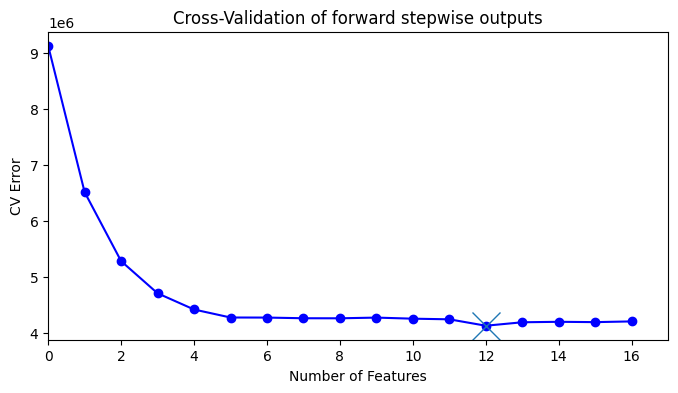

In [225]:
scores = []

for result in results:
    predictors = result[0]
    
    lm = LinearRegression(fit_intercept=True)
    scores.append(-np.mean(cross_val_score(lm, X[predictors], y, cv=10,
                                          scoring='neg_mean_squared_error')))
    
fig, axes = plt.subplots(1,1, figsize=(8,4))
axes.plot(np.arange(0, 17), scores, color='b', marker='o')
axes.plot(np.argmin(scores), np.min(scores), marker='x', markersize=20)
axes.set_xlim([0,17]);
axes.set_xlabel('Number of Features')
axes.set_ylabel('CV Error')
axes.set_title('Cross-Validation of forward stepwise outputs')

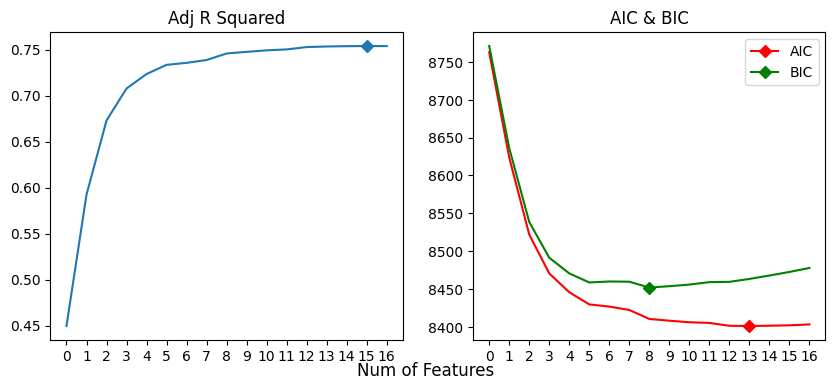

In [226]:
aic_fwd = [model[1].aic for model in results]
bic_fwd = [model[1].bic for model in results] 
r2_adj_fwd = [model[1].rsquared_adj for model in results]

fig, axes = plt.subplots(1, 2, sharex=False, sharey=False)
fig.set_figheight(4)
fig.set_figwidth(10)
fig.supxlabel('Num of Features')

axes[0].plot(r2_adj_fwd, markevery=[np.argmax(r2_adj_fwd)], marker='D')
axes[0].set_title('Adj R Squared')
axes[0].set_xticks(np.arange(0, 17, 1))

axes[1].plot(aic_fwd, markevery=[np.argmin(aic_fwd)], marker='D', color='red', label='AIC')
axes[1].plot(bic_fwd, markevery=[np.argmin(bic_fwd)], marker='D', color='green', label='BIC')
axes[1].set_xticks(np.arange(0, 17, 1))
axes[1].set_title('AIC & BIC')
axes[1].legend()

Based on the plots given above, such as cross-validation error, adj. r squared, AIC, BIC, we can select the model with 9 predictors.

In [227]:
results[8][0]

['Expend',
 'Private',
 'Room.Board',
 'perc.alumni',
 'PhD',
 'Grad.Rate',
 'P.Undergrad',
 'Accept',
 'F.Undergrad']

In [228]:
results[8][1].params

const         -2477.174381
Expend            0.225782
Private        2376.190061
Room.Board        0.971033
perc.alumni      45.804692
PhD              31.842067
Grad.Rate        21.551896
P.Undergrad      -0.123182
Accept            0.492706
F.Undergrad      -0.217447
dtype: float64

### 10.b

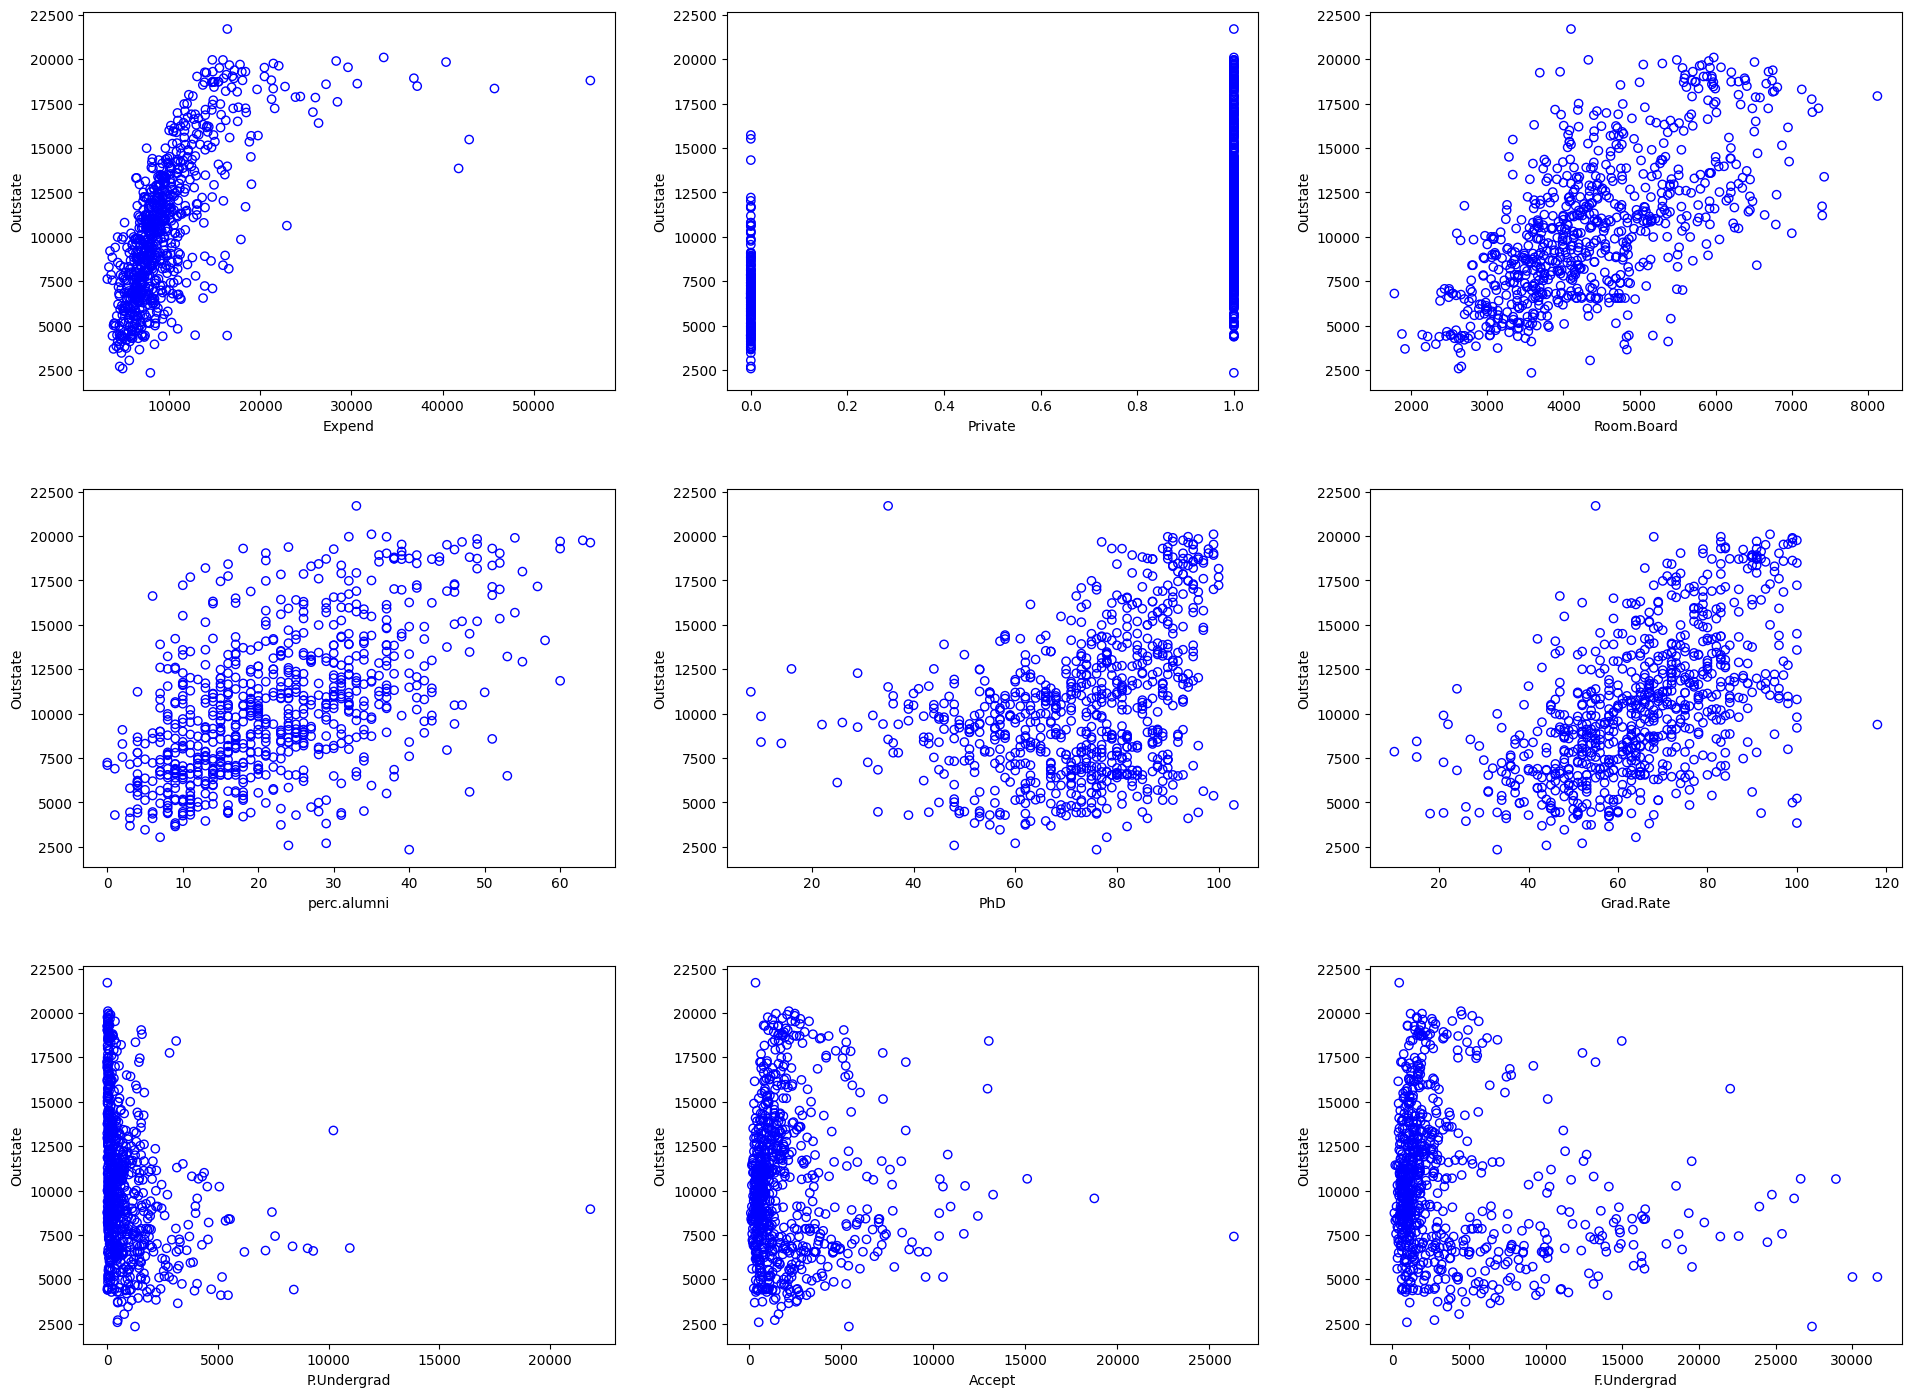

In [229]:
fig, axes = plt.subplots(3, 3, figsize=(20, 15))
fig.tight_layout(pad=5.0)

predictors = results[8][0]

for idx, predictor in enumerate(predictors):
    index = np.unravel_index(idx,(3,3))
    axes[index[0], index[1]].scatter(college[predictor], college.Outstate, facecolor='None', edgecolor='b')
    axes[index[0], index[1]].set_xlabel(predictor)
    axes[index[0], index[1]].set_ylabel('Outstate')

Based on the scatter plots, it appears that there may be a non-linear relationship between `Expend`, `PhD` and the response variable. However, it is difficult to make a clear determination based solely on the scatter plots.

In [230]:
college_spline = dmatrix("cr(Expend, df=4, constraints='center') + cr(PhD, df=4, constraints='center') +\
                        + Private + RoomBoard + percalumni + GradRate + PUndergrad + Accept + FUndergrad", 
                         data= {'Expend': X_train['Expend'],
                                 'PhD': X_train['PhD'],
                                 'Private': X_train['Private'],
                                 'RoomBoard': X_train['Room.Board'],
                                 'percalumni': X_train['perc.alumni'],
                                 'GradRate': X_train['Grad.Rate'],
                                 'PUndergrad': X_train['P.Undergrad'],
                                 'Accept': X_train['Accept'],
                                 'FUndergrad': X_train['F.Undergrad']}, return_type='dataframe')

gam = sm.OLS(y_train, college_spline).fit()
gam.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               Outstate   R-squared:                       0.786
Model:                            OLS   Adj. R-squared:                  0.779
Method:                 Least Squares   F-statistic:                     110.5
Date:                Wed, 09 Jul 2025   Prob (F-statistic):          3.45e-140
Time:                        13:50:52   Log-Likelihood:                -4159.2
No. Observations:                 466   AIC:                             8350.
Df Residuals:                     450   BIC:                             8417.
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
=============================================================================================================
                                                coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------------------------------------
Intercept                                  3273.7911    592.046      5.530      0.000    2110.274    4437.308
Private[T.True]                            1999.8711    318.529      6.278      0.000    1373.882    2625.860
cr(Expend, df=4, constraints='center')[0]  -659.9172    385.668     -1.711      0.088   -1417.852      98.017
cr(Expend, df=4, constraints='center')[1]  -806.5375    185.370     -4.351      0.000   -1170.835    -442.240
cr(Expend, df=4, constraints='center')[2]  1758.1211    444.351      3.957      0.000     884.861    2631.381
cr(Expend, df=4, constraints='center')[3]  2595.8742   1555.335      1.669      0.096    -460.747    5652.495
cr(PhD, df=4, constraints='center')[0]      196.6282    395.983      0.497      0.620    -581.577     974.833
cr(PhD, df=4, constraints='center')[1]      670.2413    580.804      1.154      0.249    -471.183    1811.666
cr(PhD, df=4, constraints='center')[2]     1932.9494    824.060      2.346      0.019     313.465    3552.434
cr(PhD, df=4, constraints='center')[3]      677.9896    478.793      1.416      0.157    -262.958    1618.938
RoomBoard                                     0.7632      0.107      7.144      0.000       0.553       0.973
percalumni                                   33.7020      9.563      3.524      0.000      14.908      52.496
GradRate                                     24.3061      6.570      3.700      0.000      11.395      37.218
PUndergrad                                   -0.0528      0.090     -0.586      0.558      -0.230       0.124
Accept                                        0.5261      0.102      5.149      0.000       0.325       0.727
FUndergrad                                   -0.2731      0.055     -4.948      0.000      -0.382      -0.165
==============================================================================
Omnibus:                       12.587   Durbin-Watson:                   2.133
Prob(Omnibus):                  0.002   Jarque-Bera (JB):               21.405
Skew:                          -0.150   Prob(JB):                     2.25e-05
Kurtosis:                       4.006   Cond. No.                     1.33e+05
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.33e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

### 10.c

In [231]:
predictors = results[8][0]
predictors

['Expend',
 'Private',
 'Room.Board',
 'perc.alumni',
 'PhD',
 'Grad.Rate',
 'P.Undergrad',
 'Accept',
 'F.Undergrad']

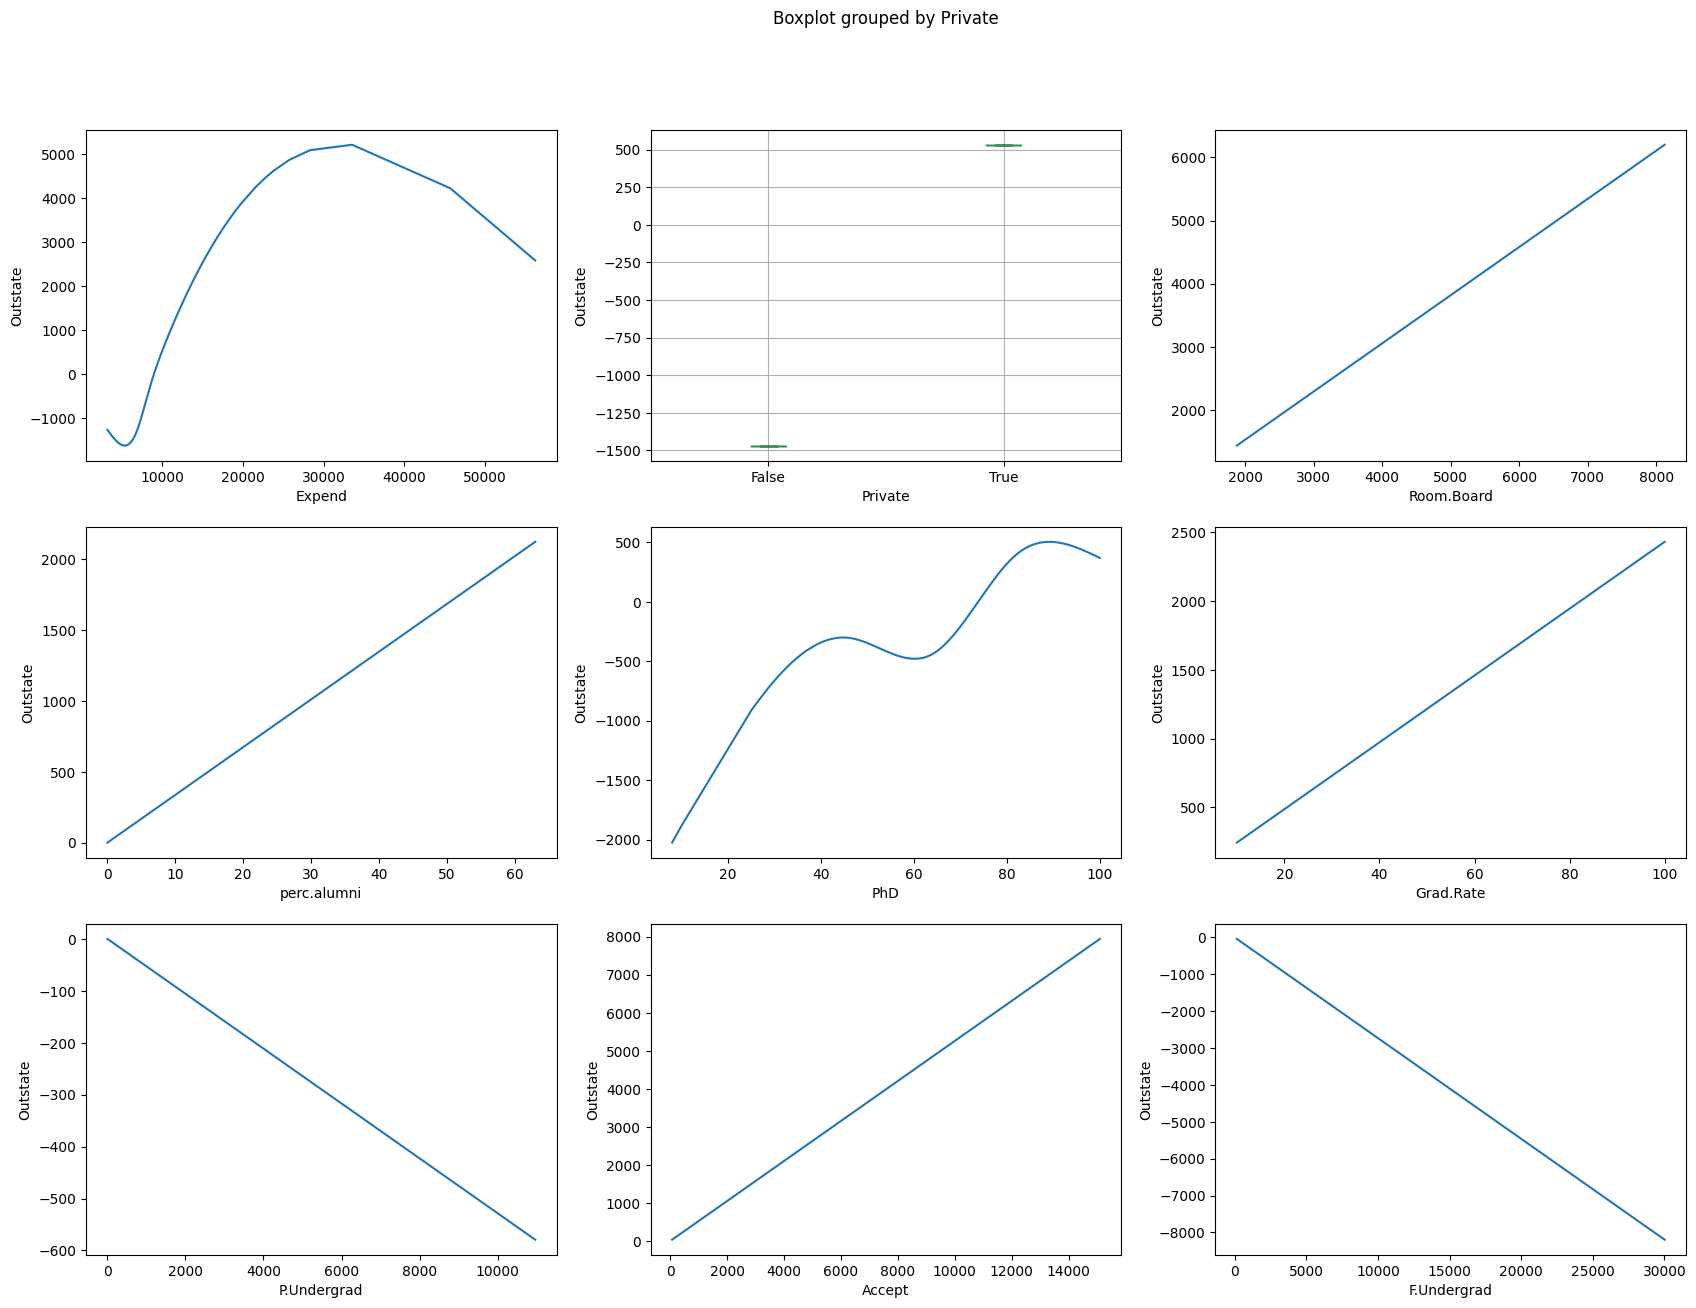

In [232]:
result = college_spline * gam.params
basis_functions = {}

for predictor in predictors:
    columns = [col for col in college_spline.columns if predictor.replace('.', '') in col]
    basis_functions[predictor] = result[columns]

fig, axes = plt.subplots(3, 3, figsize=(20, 15))

for idx, predictor in enumerate(predictors):
    index = np.unravel_index(idx, (3, 3))

    if X_train[predictor].values.dtype.type is np.int64:
        # Sort by predictor values for plotting
        sorted_idx = X_train[predictor].sort_values().index
        basis_vals = np.sum(basis_functions[predictor].loc[sorted_idx].values, axis=1)
        axes[index[0], index[1]].plot(X_train[predictor].loc[sorted_idx].values, basis_vals)
    else:
        df = pd.DataFrame(X_train.loc[:, predictor])
        df[f'{predictor}_basis_vals'] = np.sum(basis_functions[predictor].values, axis=1)
        df[f'{predictor}_basis_vals'] -= df[f'{predictor}_basis_vals'].mean()
        
        ax = df.boxplot(column=[f'{predictor}_basis_vals'], by=predictor, ax=axes[index[0], index[1]])
        ax.set_title('');
    axes[index[0], index[1]].set_xlabel(predictor)
    axes[index[0], index[1]].set_ylabel('Outstate')
#TODO

### 10.c

In [233]:
#TODO

In [234]:
#TODO

## Question 11
### 11.a

In [235]:
np.random.seed(11)
x1 = np.random.normal(size=100)
x2 = np.random.normal(size=100)
eps = np.random.normal(0, 0.5, 100)

In [236]:
y = 12.5 * x1 - 3.25 * x2 + eps

### 11.b

In [237]:
beta_1 = 5

### 11.c

In [238]:
a = y - beta_1 * x1
lm = sm.OLS(a, x2).fit()
lm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1,-3.4717,0.742,-4.677,0.000,-4.945,-1.999


In [239]:
beta_2 = lm.params[0]
beta_2

-3.4716702966793824

### 11.d

In [240]:
a = y - beta_2 * x2
lm2 = sm.OLS(a, x1).fit()
lm2.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
x1,12.5131,0.057,218.687,0.000,12.400,12.627


In [241]:
beta_1 = lm2.params[0]
beta_1

12.513067707220218

### 11.e

In [242]:
beta1 = [5]
beta2 = []
for i in range(1000):
    a = y - beta1[i] * x1
    beta_2 = LinearRegression().fit(x2.reshape(-1, 1), a).coef_[0]
    beta2.append(beta_2)
    b = y - beta_2 * x2
    beta_1 = LinearRegression().fit(x1.reshape(-1, 1), b).coef_[0]
    beta1.append(beta_1)
    if i%100 == 0:
        print(f'Beta 1: {beta_1}')
        print(f'Beta 2: {beta_2}')
        print('-'*15)

Beta 1: 12.51315636018723
Beta 2: -3.472013323078696
---------------
Beta 1: 12.517544727918063
Beta 2: -3.2939872418510117
---------------
Beta 1: 12.517544727918063
Beta 2: -3.2939872418510117
---------------
Beta 1: 12.517544727918063
Beta 2: -3.2939872418510117
---------------
Beta 1: 12.517544727918063
Beta 2: -3.2939872418510117
---------------
Beta 1: 12.517544727918063
Beta 2: -3.2939872418510117
---------------
Beta 1: 12.517544727918063
Beta 2: -3.2939872418510117
---------------
Beta 1: 12.517544727918063
Beta 2: -3.2939872418510117
---------------
Beta 1: 12.517544727918063
Beta 2: -3.2939872418510117
---------------
Beta 1: 12.517544727918063
Beta 2: -3.2939872418510117
---------------


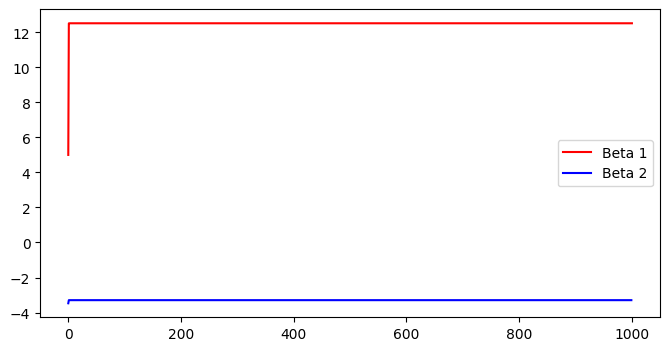

In [243]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

axes.plot(np.arange(0, 1001), beta1, color='red', label='Beta 1')
axes.plot(np.arange(0, 1000), beta2, color='blue', label='Beta 2')
axes.legend()

### 11.f

In [244]:
X = pd.DataFrame({'x1': x1, 'x2':x2})

lm = sm.OLS(y, sm.add_constant(X)).fit()
lm.summary().tables[1]

,coef,std err,t,P>|t|,[0.025,0.975]
const,-0.0081,0.051,-0.158,0.875,-0.110,0.093
x1,12.5175,0.055,228.364,0.000,12.409,12.626
x2,-3.2940,0.054,-61.311,0.000,-3.401,-3.187


In [253]:
beta1_ = lm.params.iloc[1]  # Access 1st coefficient (position 1)
beta2_ = lm.params.iloc[2]  # Access 2nd coefficient (position 2)
beta1_, beta2_

(12.517544727918066, -3.2939872418510125)

### 11.g

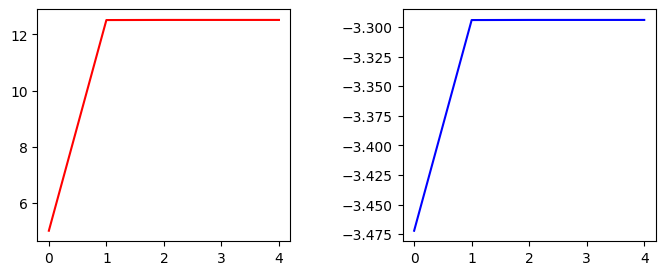

In [246]:
fig, axes = plt.subplots(1, 2, figsize=(8, 4))
fig.tight_layout(pad=5.0)

axes[0].plot(np.arange(0, 5), beta1[:5], color='red', label='Beta 1')
axes[1].plot(np.arange(0, 5), beta2[:5], color='blue', label='Beta 2')

It tooks only 1 iteration to converge in order to obtain a 'good' approximation.

## Question 12

In [247]:
np.random.seed(11)

betas = np.random.normal(size=50)
betas[0] = 5
betas

array([ 5.        , -0.286073  , -0.48456513, -2.65331856, -0.00828463,
       -0.31963136, -0.53662936,  0.31540267,  0.42105072, -1.06560298,
       -0.88623967, -0.47573349,  0.68968231,  0.56119218, -1.30554851,
       -1.11947526,  0.73683739,  1.57463407, -0.03107509, -0.68344663,
        1.0956297 , -0.30957664,  0.72575222,  1.54907163,  0.63007982,
        0.07349324,  0.73227135, -0.64257539, -0.17809318, -0.57395456,
       -0.20437532, -0.4864951 , -0.18577532, -0.38053642,  0.08897764,
        0.06367166,  0.29634711,  1.40277112, -1.54686257,  1.29561858,
       -0.23725045, -1.23234621, -0.17241977,  0.09183837,  1.06755846,
       -1.06163445,  0.21734821,  0.1178195 , -1.68411089, -1.18575527])

In [248]:
np.random.seed(32)

X = np.random.normal(0, 10, (1000, 50))
eps = np.random.normal(0, 0.5, 1000)

Y = np.matmul(X, betas) + eps

### Backfitting

In [249]:
# performing single backfitting 
betas_est = np.zeros((50, ))

for i in range(X.shape[1]):
    a = Y - np.dot(X[:, i], betas_est[i])
    coef = sm.OLS(a, np.delete(X, i, axis=1)).fit()
    
    for j in range(len(betas_est)):
        if j==i:
            continue
        elif j < i:
            betas_est[j] = coef.params[j]
        else:
            betas_est[j] = coef.params[j-1]
betas_est

array([ 4.99829178, -0.28700315, -0.48481321, -2.65044082, -0.00739431,
       -0.32120697, -0.5351145 ,  0.31497741,  0.42170467, -1.06803816,
       -0.88362053, -0.47636737,  0.68707127,  0.56241581, -1.30697166,
       -1.11944369,  0.73498898,  1.57448995, -0.03297292, -0.68353156,
        1.09895985, -0.30745037,  0.72586026,  1.54532118,  0.62979689,
        0.07290009,  0.73206502, -0.64439188, -0.18067431, -0.57330019,
       -0.20351183, -0.48536656, -0.18643082, -0.37993754,  0.09166383,
        0.06403984,  0.29683673,  1.40550403, -1.54848952,  1.29447158,
       -0.23744383, -1.23247216, -0.17182062,  0.09065382,  1.06703095,
       -1.06040381,  0.22033307,  0.11999288, -1.6850701 , -1.18353693])

In [250]:
multiple_lm = LinearRegression().fit(X, Y)
multiple_lm.coef_

array([ 4.99823369, -0.2870116 , -0.48473564, -2.65043351, -0.00742254,
       -0.32123079, -0.53516187,  0.31496436,  0.42166111, -1.06809739,
       -0.88364261, -0.47638982,  0.68708133,  0.56236332, -1.30695965,
       -1.11948478,  0.73485365,  1.57448256, -0.03299317, -0.68347939,
        1.09893721, -0.30743505,  0.72589663,  1.54534595,  0.62970843,
        0.07298647,  0.73207363, -0.64437758, -0.18064609, -0.57333914,
       -0.20349148, -0.48529116, -0.18647098, -0.38002365,  0.0915651 ,
        0.06401077,  0.29686398,  1.40562693, -1.54847891,  1.2945238 ,
       -0.2375091 , -1.23248102, -0.17180182,  0.09063396,  1.06699369,
       -1.0604626 ,  0.22036483,  0.12005332, -1.68516538, -1.18346843])

In [251]:
distances = np.zeros((50, ))
betas_est = np.zeros((50, ))

for iteration in np.arange(50):
    for i in range(X.shape[1]):
        a = Y - np.dot(X[:, i], betas_est[i])
        coef = sm.OLS(a, np.delete(X, i, axis=1)).fit()

        for j in range(len(betas_est)):
            if j==i:
                continue
            elif j < i:
                betas_est[j] = coef.params[j]
            else:
                betas_est[j] = coef.params[j-1]
    
    distances[iteration] = distance.euclidean(betas_est, multiple_lm.coef_)

Text(0.5, 1.0, 'Distance between mlm & backfitting')

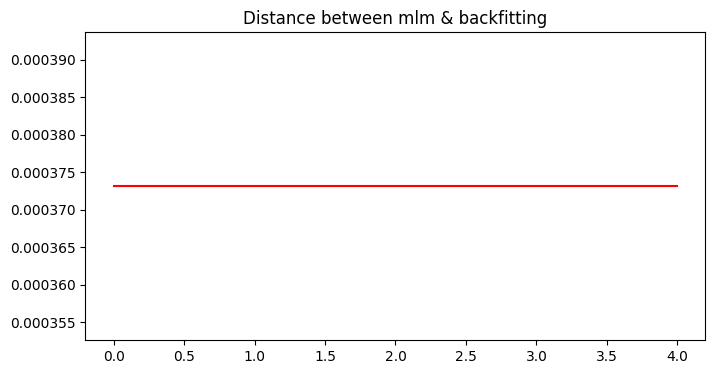

In [252]:
fig, axes = plt.subplots(1, 1, figsize=(8, 4))

axes.plot(np.arange(0, 5), distances[:5], color='red')
axes.set_title('Distance between mlm & backfitting')